# Économétrie pure

On veut valider empiriquement l'équation suivante : 
$$\phi_{t}^{i} = \frac{1}{c_{\phi}^{i}}(P^{i}-A^{i}(E_{t}^{i}-\Psi_{t}^{i}))$$
Avec : 
- $\phi_{t}^{i}$: Flux mensuel de communication environnementale au mois $t$ pour l'entreprise $i$.
- $c_{t}^{i}$: Coût marginal de communication.
- $E_{t}^{i}$: Score environnemental au mois $t$ pour l'entreprise $i$.
- $\Psi_{t}^{i}$: Valeur environnementale fondamentale de l'entreprise $i$ au mois $t$.


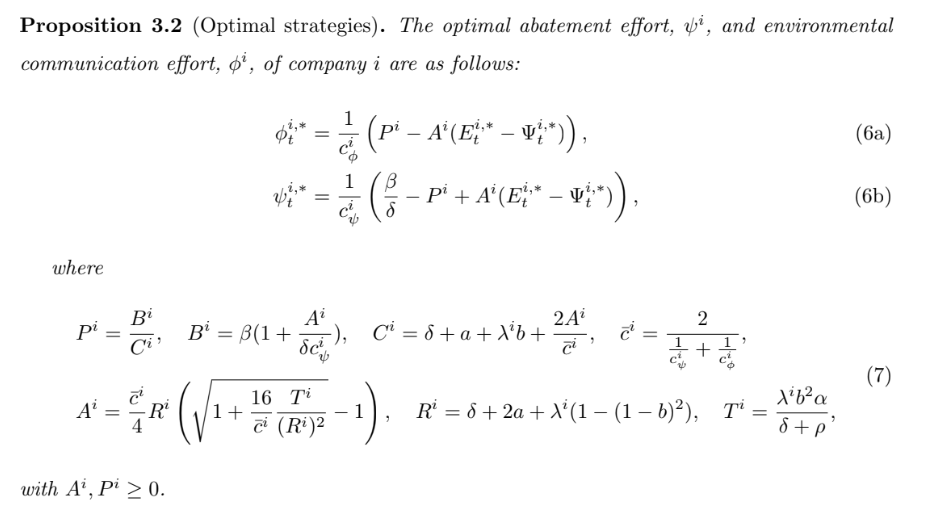

## 1st step

On cherche à construire un proxy $\hat{\phi}^{i}_{t}$ pour $\phi^{i}_{t}$. 


Nous construisons un score de communication environnementale, $\hat{\varepsilon}^{i}_{1,t}$, purifié de l'effet des controverses environnementales, défini comme les résidus de la régression Within de $Rep^{i}_{t}$ sur $Con^{i}_{t}$ avec des effets fixes dans le temps et pour l'entreprise, où $Con^{i}_{t}$ est instrumenté par $Con^{i}_{t-1}$ :
\begin{equation}
Rep^{i}_{t} = \alpha^{i}_{1,1} + \alpha_{1,2,t} + \beta_1 Con^{i,*}_{t} + \varepsilon^{i}_{1,t}
\end{equation}

où $Con^{i,*}_{t} = \hat{\beta}_2 Con^{i}_{t-1}$ est la prédiction de la régression suivante :
\begin{equation}
Con^{i}_{t} = \alpha^{i}_{2,1} + \alpha_{2,2,t} + \beta_2 Con^{i}_{t-1} + \varepsilon^{i}_{2,t}.
\end{equation}

--------------- TESTER PERTINENCE DE L'INSTRUMENT ----------------

Le test de pertinence de l'instrument $Con^{i}_{t}$ donne un $R^2$ de la régression de $Con^{i}_{t}$ sur $Con^{i}_{t-1}$ de 78,3\%. De plus, la condition d'exogénéité faible est satisfaite, assurant que les résidus de la régression 2SLS peuvent être utilisés pour construire un proxy du score de communication environnementale. Nous définissons alors un proxy du flux de communication environnementale, $\hat{\varphi}^{i}_{t}$, comme la première différence du score de communication environnementale :
\begin{equation}
\hat{\varphi}^{i}_{t} \equiv \hat{\varepsilon}^{i}_{1,t} - \hat{\varepsilon}^{i}_{1,t-1}.
\end{equation}

Ce proxy représente le flux de communication environnementale de l'entreprise i au mois t.

In [1]:
!pip3 install openpyxl
!pip3 install linearmodels
!pip3 install seaborn
import pandas as pd
import numpy as np
import linearmodels
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from linearmodels.panel import PanelOLS, FirstDifferenceOLS, compare, RandomEffects
from tqdm import tqdm
from linearmodels.panel.model import MissingValueWarning

warnings.filterwarnings('ignore', category=MissingValueWarning)

In [2]:
df = pd.read_pickle('data_pannels.pkl')

# Convertir la colonne 'Date' en type datetime
df['Date'] = pd.to_datetime(df['Date'])

df['ESG'] = df['ESG'].str.replace(',', '.').astype(float)


# Définir l'index sur les colonnes 'idEntreprise' et 'Date'
df.set_index(['idEntreprise', 'Date'], inplace=True)

df['Con_lag'] = df.groupby(level=0)['Controverse'].shift(1)

df

score_comm        ESG         PFL    Diff_z  \
idEntreprise Date                                                      
1            2009-01-01   -0.015203  60.866464  100.000000  5.475597   
             2009-02-01   -0.014819  61.046910  100.000000  5.339223   
             2009-03-01   -0.009638  61.223748  100.000000  5.534291   
             2009-04-01   -0.019162  60.841493  100.000000  5.639993   
             2009-05-01   -0.019016  60.590206  100.000000  5.892612   
...                             ...        ...         ...       ...   
18386        2022-12-01   -0.316436  49.680590   99.219927  2.391562   
             2023-01-01   -0.312305  49.648089   99.219927  2.386211   
             2023-02-01   -0.311182  49.616238   99.219927  2.347607   
             2023-03-01   -0.315421  49.585025   99.219927  2.344902   
             2023-04-01   -0.318254  50.109991   99.219927  1.663395   

                         Controverse  \
idEntreprise Date                      
1            2009-01-01    29.837788   
             2009-02-01    23.870230   
             2009-03-01    19.096184   
             2009-04-01    26.388059   
             2009-05-01    43.332669   
...                              ...   
18386        2022-12-01     0.278300   
             2023-01-01     0.222640   
             2023-02-01     0.178112   
             2023-03-01     0.142490   
             2023-04-01     0.113992   

                                                    GICS industry group  \
idEntreprise Date                                                         
1            2009-01-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-02-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-03-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-04-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-05-01  Pharmaceuticals, Biotechnology & Life Sciences   
...                                                                 ...   
18386        2022-12-01                              Financial Services   
             2023-01-01                              Financial Services   
             2023-02-01                              Financial Services   
             2023-03-01                              Financial Services   
             2023-04-01                              Financial Services   

                           GICS sub-industry    Con_lag  
idEntreprise Date                                        
1            2009-01-01      Pharmaceuticals        NaN  
             2009-02-01      Pharmaceuticals  29.837788  
             2009-03-01      Pharmaceuticals  23.870230  
             2009-04-01      Pharmaceuticals  19.096184  
             2009-05-01      Pharmaceuticals  26.388059  
...                                      ...        ...  
18386        2022-12-01  Specialized Finance   0.347875  
             2023-01-01  Specialized Finance   0.278300  
             2023-02-01  Specialized Finance   0.222640  
             2023-03-01  Specialized Finance   0.178112  
             2023-04-01  Specialized Finance   0.142490  

[17028 rows x 8 columns]

In [3]:
# Sélectionnez les colonnes pertinentes pour le calcul de la corrélation
variables = ['score_comm', 'ESG', 'PFL', 'Controverse']
correlation_matrix = df[variables].corr()
correlation_matrix

,score_comm,ESG,PFL,Controverse
score_comm,1.000000,-0.085757,-0.023474,0.053562
ESG,-0.085757,1.000000,0.615644,0.284285
PFL,-0.023474,0.615644,1.000000,0.123763
Controverse,0.053562,0.284285,0.123763,1.000000


Malgré le fait que le score de communication environemental ait été créer à partir des variations de PFL, on observe une faible corrélation entre ces deux variables. Egalement la corrélation reste faible entre ce score de communication, et les autres variables

### Etape 1 : Construire la variable Con_star

#### Construction de Con_star

In [4]:
# Première étape: Régression de Con sur Con_lag avec effets fixes
first_stage_fix = PanelOLS(dependent=df['Controverse'], 
                       exog=df[['Con_lag']],
                       entity_effects=True, 
                       time_effects=True)
res_first_stage_fix = first_stage_fix.fit()

# Ajouter les valeurs ajustées à df
df['Con_star_fix'] = res_first_stage_fix.fitted_values

df

score_comm        ESG         PFL    Diff_z  \
idEntreprise Date                                                      
1            2009-01-01   -0.015203  60.866464  100.000000  5.475597   
             2009-02-01   -0.014819  61.046910  100.000000  5.339223   
             2009-03-01   -0.009638  61.223748  100.000000  5.534291   
             2009-04-01   -0.019162  60.841493  100.000000  5.639993   
             2009-05-01   -0.019016  60.590206  100.000000  5.892612   
...                             ...        ...         ...       ...   
18386        2022-12-01   -0.316436  49.680590   99.219927  2.391562   
             2023-01-01   -0.312305  49.648089   99.219927  2.386211   
             2023-02-01   -0.311182  49.616238   99.219927  2.347607   
             2023-03-01   -0.315421  49.585025   99.219927  2.344902   
             2023-04-01   -0.318254  50.109991   99.219927  1.663395   

                         Controverse  \
idEntreprise Date                      
1            2009-01-01    29.837788   
             2009-02-01    23.870230   
             2009-03-01    19.096184   
             2009-04-01    26.388059   
             2009-05-01    43.332669   
...                              ...   
18386        2022-12-01     0.278300   
             2023-01-01     0.222640   
             2023-02-01     0.178112   
             2023-03-01     0.142490   
             2023-04-01     0.113992   

                                                    GICS industry group  \
idEntreprise Date                                                         
1            2009-01-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-02-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-03-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-04-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-05-01  Pharmaceuticals, Biotechnology & Life Sciences   
...                                                                 ...   
18386        2022-12-01                              Financial Services   
             2023-01-01                              Financial Services   
             2023-02-01                              Financial Services   
             2023-03-01                              Financial Services   
             2023-04-01                              Financial Services   

                           GICS sub-industry    Con_lag  Con_star_fix  
idEntreprise Date                                                      
1            2009-01-01      Pharmaceuticals        NaN           NaN  
             2009-02-01      Pharmaceuticals  29.837788     26.860962  
             2009-03-01      Pharmaceuticals  23.870230     21.488769  
             2009-04-01      Pharmaceuticals  19.096184     17.191015  
             2009-05-01      Pharmaceuticals  26.388059     23.755401  
...                                      ...        ...           ...  
18386        2022-12-01  Specialized Finance   0.347875      0.313169  
             2023-01-01  Specialized Finance   0.278300      0.250535  
             2023-02-01  Specialized Finance   0.222640      0.200428  
             2023-03-01  Specialized Finance   0.178112      0.160342  
             2023-04-01  Specialized Finance   0.142490      0.128274  

[17028 rows x 9 columns]

#### Analyse de Con_star et de sa régression

In [5]:
print(res_first_stage_fix)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.8050
Estimator:                   PanelOLS   R-squared (Between):              0.9894
No. Observations:               16929   R-squared (Within):               0.8349
Date:                Fri, May 03 2024   R-squared (Overall):              0.9519
Time:                        07:47:45   Log-likelihood                -5.727e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   6.875e+04
Entities:                          99   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(1,16659)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):          6.875e+04
                            

Voici une explication des principaux éléments de la sortie :

        La variable dépendante (Dep. Variable) est 'Controverse'.
        Le coefficient de détermination (R-squared) est de 0.7213, ce qui signifie que le modèle explique environ 72.13 % de la variance de la variable dépendante.
        Le R-squared (Between) représente la proportion de variance expliquée par les variations entre les entités.
        Le R-squared (Within) représente la proportion de variance expliquée par les variations à l'intérieur des entités.
        Le R-squared (Overall) représente la proportion de variance expliquée par le modèle dans son ensemble.

    Informations sur l'estimation :
        Le nombre d'observations est de 12141 (on perds des estimations à cause de l'effet within.

    Statistiques de test :
        Le F-statistic est utilisé pour tester la significativité globale du modèle. Ici, il est de 3.08e+04 avec un P-value de 0.0000, indiquant que le modèle dans son ensemble est statistiquement significatif.
        Le F-statistic (robust) est une version robuste du F-statistic qui est moins sensible aux violations des hypothèses de base de la régression linéaire.
        Le F-test for Poolability est utilisé pour tester la validité des effets fixes. Le P-value de ce test est également très faible (0.0000), ce qui suggère que les effets fixes sont statistiquement significatifs.

    Estimations des paramètres :
        Le coefficient de la variable explicative 'Con_lag' est de 0.8551. Cela signifie que, toutes choses égales par ailleurs, une augmentation d'une unité de 'Con_lag' est associée à une augmentation de 0.8551 unité de 'Controverse'.
        Les erreurs standard fournissent une indication de la précision des estimations des coefficients.
        Les valeurs de T-statistic et de P-value permettent de tester l'importance individuelle des coefficients. Ici, la P-value associée à 'Con_lag' est très faible (0.0000), indiquant que ce coefficient est statistiquement significatif.

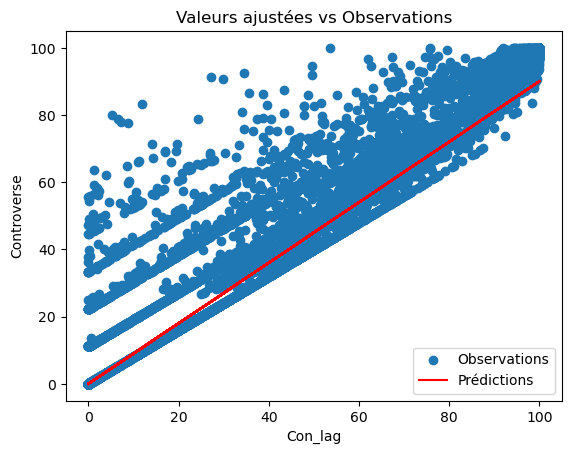

In [6]:
plt.scatter(df['Con_lag'], df['Controverse'], label='Observations')
plt.plot(df['Con_lag'], df['Con_star_fix'], color='red', label='Prédictions')
plt.xlabel('Con_lag')
plt.ylabel('Controverse')
plt.legend()
plt.title('Valeurs ajustées vs Observations')
plt.show()

In [7]:
# Calcul des critères R2 ajustés, AIC et BIC à la main

# Calcul du R2 ajusté
n = res_first_stage_fix.nobs
k = res_first_stage_fix.df_model
r2 = res_first_stage_fix.rsquared
r2_adjusted_fix = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

num_params_fix = res_first_stage_fix.params.shape[0]
nobs_fix = res_first_stage_fix.nobs
resid_ss_fix = np.sum(res_first_stage_fix.resids ** 2)
aic_fix = 2 * num_params_fix - 2 * np.log(resid_ss_fix)
bic_fix = np.log(nobs_fix) * num_params_fix - 2 * np.log(resid_ss_fix)

print("R2 ajusté:", r2_adjusted_fix)
print("AIC:", aic_fix)
print("BIC:", bic_fix)

R2 ajusté: 0.8017969909275018
AIC: -25.330456606711486
BIC: -17.593673200074235


Test de Hausman : Le test de Hausman est utilisé pour évaluer la spécification appropriée des modèles de régression dans lesquels il y a une incertitude sur le choix entre des effets fixes et des effets aléatoires. Plus spécifiquement, il est utilisé dans les modèles de panel pour déterminer si les effets fixes sont préférables aux effets aléatoires.

In [8]:
# Créer un modèle RandomEffects
random_effects_model = RandomEffects(df['Controverse'], df[['Con_lag']])

# Ajuster le modèle
res_random_effects = random_effects_model.fit()

# Comparer les estimations des effets fixes et des effets aléatoires
hausman_test = compare({'Effets Fixes': res_first_stage_fix, 'Effets Aléatoires': res_random_effects})
print(hausman_test)

                     Model Comparison                    
                           Effets Fixes Effets Aléatoires
---------------------------------------------------------
Dep. Variable               Controverse       Controverse
Estimator                      PanelOLS     RandomEffects
No. Observations                  16929             16929
Cov. Est.                    Unadjusted        Unadjusted
R-squared                        0.8050            0.9587
R-Squared (Within)               0.8349            0.8312
R-Squared (Between)              0.9894            0.9995
R-Squared (Overall)              0.9519            0.9587
F-statistic                   6.875e+04         3.926e+05
P-value (F-stat)                 0.0000            0.0000
=====================     =============   ===============
Con_lag                          0.9002            0.9830
                               (262.21)          (626.60)
======================= =============== =================
Effects       

    Hypothèse Nulle (H0) : Les variables explicatives (exogènes) ne sont pas corrélées avec les effets spécifiques aux entités.

    Hypothèse Alternative (H1) : Les variables explicatives (exogènes) sont corrélées avec les effets spécifiques aux entités.

Statistique de test :

La statistique de test utilisée dans le test de Hausman est généralement basée sur la différence entre les estimateurs des effets fixes et des effets aléatoires. Cette statistique suit approximativement une distribution de chi carré sous l'hypothèse nulle.

In [9]:
from scipy.stats import chi2

def hausman_test(fe_model, re_model):
    b_fe = fe_model.params
    b_re = re_model.params
    v_fe = fe_model.cov
    v_re = re_model.cov
    
    b_diff = b_fe - b_re
    v_diff = v_fe - v_re
    
    hausman_stat = b_diff.T @ np.linalg.inv(v_diff) @ b_diff
    df = b_diff.size
    
    p_value = chi2.sf(hausman_stat, df)
    
    return hausman_stat, p_value

# Suppose fe_model et re_model sont les résultats des modèles à effets fixes et à effets aléatoires respectivement
hausman_stat, p_value = hausman_test(res_first_stage_fix, res_random_effects)
print("Test de Hausman - Statistique : {:.4f}".format(hausman_stat))
print("Test de Hausman - P-valeur : {:.4f}".format(p_value))


Test de Hausman - Statistique : 734.0585
Test de Hausman - P-valeur : 0.0000


#### Construction de Con_star sans effet fixe

In [10]:
# Première étape: Régression de Con sur Con_lag avec effets fixes
first_stage_random = PanelOLS(dependent=df['Controverse'], 
                       exog=df[['Con_lag']],
                       entity_effects=False, 
                       time_effects=True)
res_first_stage_random = first_stage_random.fit()

# Ajouter les valeurs ajustées à df
df['Con_star_random'] = res_first_stage_random.fitted_values

df

score_comm        ESG         PFL    Diff_z  \
idEntreprise Date                                                      
1            2009-01-01   -0.015203  60.866464  100.000000  5.475597   
             2009-02-01   -0.014819  61.046910  100.000000  5.339223   
             2009-03-01   -0.009638  61.223748  100.000000  5.534291   
             2009-04-01   -0.019162  60.841493  100.000000  5.639993   
             2009-05-01   -0.019016  60.590206  100.000000  5.892612   
...                             ...        ...         ...       ...   
18386        2022-12-01   -0.316436  49.680590   99.219927  2.391562   
             2023-01-01   -0.312305  49.648089   99.219927  2.386211   
             2023-02-01   -0.311182  49.616238   99.219927  2.347607   
             2023-03-01   -0.315421  49.585025   99.219927  2.344902   
             2023-04-01   -0.318254  50.109991   99.219927  1.663395   

                         Controverse  \
idEntreprise Date                      
1            2009-01-01    29.837788   
             2009-02-01    23.870230   
             2009-03-01    19.096184   
             2009-04-01    26.388059   
             2009-05-01    43.332669   
...                              ...   
18386        2022-12-01     0.278300   
             2023-01-01     0.222640   
             2023-02-01     0.178112   
             2023-03-01     0.142490   
             2023-04-01     0.113992   

                                                    GICS industry group  \
idEntreprise Date                                                         
1            2009-01-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-02-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-03-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-04-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-05-01  Pharmaceuticals, Biotechnology & Life Sciences   
...                                                                 ...   
18386        2022-12-01                              Financial Services   
             2023-01-01                              Financial Services   
             2023-02-01                              Financial Services   
             2023-03-01                              Financial Services   
             2023-04-01                              Financial Services   

                           GICS sub-industry    Con_lag  Con_star_fix  \
idEntreprise Date                                                       
1            2009-01-01      Pharmaceuticals        NaN           NaN   
             2009-02-01      Pharmaceuticals  29.837788     26.860962   
             2009-03-01      Pharmaceuticals  23.870230     21.488769   
             2009-04-01      Pharmaceuticals  19.096184     17.191015   
             2009-05-01      Pharmaceuticals  26.388059     23.755401   
...                                      ...        ...           ...   
18386        2022-12-01  Specialized Finance   0.347875      0.313169   
             2023-01-01  Specialized Finance   0.278300      0.250535   
             2023-02-01  Specialized Finance   0.222640      0.200428   
             2023-03-01  Specialized Finance   0.178112      0.160342   
             2023-04-01  Specialized Finance   0.142490      0.128274   

                         Con_star_random  
idEntreprise Date                         
1            2009-01-01              NaN  
             2009-02-01        28.868474  
             2009-03-01        23.094779  
             2009-04-01        18.475823  
             2009-05-01        25.530813  
...                                  ...  
18386        2022-12-01         0.336574  
             2023-01-01         0.269259  
             2023-02-01         0.215407  
             2023-03-01         0.172326  
             2023-04-01         0.137861  

[17028 rows x 10 columns]

In [11]:
print(res_first_stage_random)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.9318
Estimator:                   PanelOLS   R-squared (Between):              0.9987
No. Observations:               16929   R-squared (Within):               0.8329
Date:                Fri, May 03 2024   R-squared (Overall):              0.9584
Time:                        07:47:49   Log-likelihood                -5.757e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                    2.29e+05
Entities:                          99   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(1,16757)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):           2.29e+05
                            

In [12]:
# Calcul des critères R2 ajusté, AIC et BIC à la main

n = res_first_stage_random.nobs
k = res_first_stage_random.df_model
r2 = res_first_stage_random.rsquared
r2_adjusted_random = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

num_params_random = res_first_stage_random.params.shape[0]
nobs_random = res_first_stage_random.nobs
resid_ss_random = np.sum(res_first_stage_random.resids ** 2)
aic_random = 2 * num_params_random - 2 * np.log(resid_ss_random)
bic_random = np.log(nobs_random) * num_params_random - 2 * np.log(resid_ss_random)

print("R2 ajusté:", r2_adjusted_random)
print("AIC:", aic_random)
print("BIC:", bic_random)

R2 ajusté: 0.9311176804784292
AIC: -25.40019640343534
BIC: -17.663412996798094


##### Résumé comparaison effet fixe et effet aléatoire

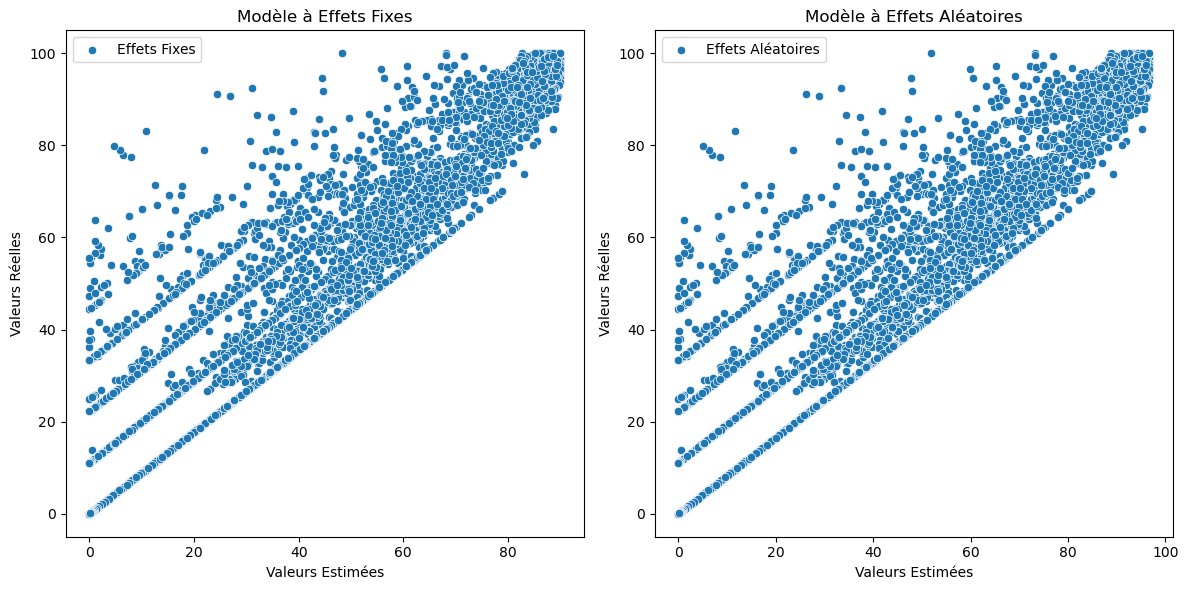

Comparaison des Performances :
-----------------------------------
           Modèle  R-squared ajusté        AIC        BIC  Nombre d'observations
     Effets Fixes          0.801797 -25.330457 -17.593673                  16929
Effets Aléatoires          0.931118 -25.400196 -17.663413                  16929


In [13]:
# R-squared
r2_adj_fixed = r2_adjusted_fix
r2_adj_random = r2_adjusted_random

# AIC
aic_fixed = aic_fix
aic_random = aic_random

# BIC
bic_fixed = bic_fix
bic_random = bic_random

# Nombre d'observations
nobs_fixed = nobs_fix
nobs_random = nobs_random

# 3. Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=res_first_stage_fix.fitted_values.squeeze(), y=df['Controverse'], label='Effets Fixes')
plt.xlabel('Valeurs Estimées')
plt.ylabel('Valeurs Réelles')
plt.title('Modèle à Effets Fixes')

plt.subplot(1, 2, 2)
sns.scatterplot(x=res_first_stage_random.fitted_values.squeeze(), y=df['Controverse'], label='Effets Aléatoires')
plt.xlabel('Valeurs Estimées')
plt.ylabel('Valeurs Réelles')
plt.title('Modèle à Effets Aléatoires')

plt.tight_layout()
plt.show()


# Création du tableau de comparaison des performances
performance_comparison = pd.DataFrame({
    'Modèle': ['Effets Fixes', 'Effets Aléatoires'],
    'R-squared ajusté': [r2_adj_fixed, r2_adj_random],
    'AIC': [aic_fixed, aic_random],
    'BIC': [bic_fixed, bic_random],
    'Nombre d\'observations': [nobs_fixed, nobs_random]
})

# Affichage du tableau
print("Comparaison des Performances :")
print("-----------------------------------")
performance_comparaison = performance_comparison.to_string(index=False)
print(performance_comparaison)

Conclusion : On a un meilleur R2 ajusté, AIC et BIC dans le modèle à effet aléatoire. En revanche, les tests nous affirme que l'effet fixe est préferable, donc on préfère prendre un modèle à effet fixe, tout en se rappelant que les critères d'informations semblaient dire l'inverse.

En somme, l'ajout d'un effet fixe dans le modèle ne semble pas améliorer grandement le modèle... ? Même si les test sont significatifs ?

In [14]:
df['Con_star'] = df['Con_star_fix']
df.drop(columns=['Con_star_fix','Con_star_random'], inplace=True)
df

score_comm        ESG         PFL    Diff_z  \
idEntreprise Date                                                      
1            2009-01-01   -0.015203  60.866464  100.000000  5.475597   
             2009-02-01   -0.014819  61.046910  100.000000  5.339223   
             2009-03-01   -0.009638  61.223748  100.000000  5.534291   
             2009-04-01   -0.019162  60.841493  100.000000  5.639993   
             2009-05-01   -0.019016  60.590206  100.000000  5.892612   
...                             ...        ...         ...       ...   
18386        2022-12-01   -0.316436  49.680590   99.219927  2.391562   
             2023-01-01   -0.312305  49.648089   99.219927  2.386211   
             2023-02-01   -0.311182  49.616238   99.219927  2.347607   
             2023-03-01   -0.315421  49.585025   99.219927  2.344902   
             2023-04-01   -0.318254  50.109991   99.219927  1.663395   

                         Controverse  \
idEntreprise Date                      
1            2009-01-01    29.837788   
             2009-02-01    23.870230   
             2009-03-01    19.096184   
             2009-04-01    26.388059   
             2009-05-01    43.332669   
...                              ...   
18386        2022-12-01     0.278300   
             2023-01-01     0.222640   
             2023-02-01     0.178112   
             2023-03-01     0.142490   
             2023-04-01     0.113992   

                                                    GICS industry group  \
idEntreprise Date                                                         
1            2009-01-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-02-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-03-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-04-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-05-01  Pharmaceuticals, Biotechnology & Life Sciences   
...                                                                 ...   
18386        2022-12-01                              Financial Services   
             2023-01-01                              Financial Services   
             2023-02-01                              Financial Services   
             2023-03-01                              Financial Services   
             2023-04-01                              Financial Services   

                           GICS sub-industry    Con_lag   Con_star  
idEntreprise Date                                                   
1            2009-01-01      Pharmaceuticals        NaN        NaN  
             2009-02-01      Pharmaceuticals  29.837788  26.860962  
             2009-03-01      Pharmaceuticals  23.870230  21.488769  
             2009-04-01      Pharmaceuticals  19.096184  17.191015  
             2009-05-01      Pharmaceuticals  26.388059  23.755401  
...                                      ...        ...        ...  
18386        2022-12-01  Specialized Finance   0.347875   0.313169  
             2023-01-01  Specialized Finance   0.278300   0.250535  
             2023-02-01  Specialized Finance   0.222640   0.200428  
             2023-03-01  Specialized Finance   0.178112   0.160342  
             2023-04-01  Specialized Finance   0.142490   0.128274  

[17028 rows x 9 columns]

### Etape 2 du 2SLS : Régression de PFL sur Con (instrumenté par Con_star avec effets fixes)

In [15]:
second_stage = PanelOLS(dependent=df['PFL'], 
                        exog=df[['Con_star']],
                        entity_effects=True, 
                        time_effects=True)
res_second_stage = second_stage.fit()

# Ajouter les valeurs ajustées à df
df['Rep_2SLS'] = res_second_stage.fitted_values
df['epsilon_hat'] = res_second_stage.resids

# Calcul du proxy du flux de communication environnementale
df['phi_hat'] = df.groupby(level=0)['epsilon_hat'].diff()

df

score_comm        ESG         PFL    Diff_z  \
idEntreprise Date                                                      
1            2009-01-01   -0.015203  60.866464  100.000000  5.475597   
             2009-02-01   -0.014819  61.046910  100.000000  5.339223   
             2009-03-01   -0.009638  61.223748  100.000000  5.534291   
             2009-04-01   -0.019162  60.841493  100.000000  5.639993   
             2009-05-01   -0.019016  60.590206  100.000000  5.892612   
...                             ...        ...         ...       ...   
18386        2022-12-01   -0.316436  49.680590   99.219927  2.391562   
             2023-01-01   -0.312305  49.648089   99.219927  2.386211   
             2023-02-01   -0.311182  49.616238   99.219927  2.347607   
             2023-03-01   -0.315421  49.585025   99.219927  2.344902   
             2023-04-01   -0.318254  50.109991   99.219927  1.663395   

                         Controverse  \
idEntreprise Date                      
1            2009-01-01    29.837788   
             2009-02-01    23.870230   
             2009-03-01    19.096184   
             2009-04-01    26.388059   
             2009-05-01    43.332669   
...                              ...   
18386        2022-12-01     0.278300   
             2023-01-01     0.222640   
             2023-02-01     0.178112   
             2023-03-01     0.142490   
             2023-04-01     0.113992   

                                                    GICS industry group  \
idEntreprise Date                                                         
1            2009-01-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-02-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-03-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-04-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-05-01  Pharmaceuticals, Biotechnology & Life Sciences   
...                                                                 ...   
18386        2022-12-01                              Financial Services   
             2023-01-01                              Financial Services   
             2023-02-01                              Financial Services   
             2023-03-01                              Financial Services   
             2023-04-01                              Financial Services   

                           GICS sub-industry    Con_lag   Con_star  Rep_2SLS  \
idEntreprise Date                                                              
1            2009-01-01      Pharmaceuticals        NaN        NaN       NaN   
             2009-02-01      Pharmaceuticals  29.837788  26.860962 -1.963438   
             2009-03-01      Pharmaceuticals  23.870230  21.488769 -1.570751   
             2009-04-01      Pharmaceuticals  19.096184  17.191015 -1.256601   
             2009-05-01      Pharmaceuticals  26.388059  23.755401 -1.736433   
...                                      ...        ...        ...       ...   
18386        2022-12-01  Specialized Finance   0.347875   0.313169 -0.022891   
             2023-01-01  Specialized Finance   0.278300   0.250535 -0.018313   
             2023-02-01  Specialized Finance   0.222640   0.200428 -0.014651   
             2023-03-01  Specialized Finance   0.178112   0.160342 -0.011720   
             2023-04-01  Specialized Finance   0.142490   0.128274 -0.009376   

                         epsilon_hat   phi_hat  
idEntreprise Date                               
1            2009-01-01          NaN       NaN  
             2009-02-01    34.529597       NaN  
             2009-03-01    32.696721 -1.832876  
             2009-04-01    31.472761 -1.223960  
             2009-05-01    31.848970  0.376209  
...                              ...       ...  
18386        2022-12-01    43.352229  0.106026  
             2023-01-01    43.170426 -0.181803  
             2023-02-01    43.292482  0.122056  
           

##### Analyse de la regression :

In [16]:
print(res_second_stage)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    PFL   R-squared:                        0.0081
Estimator:                   PanelOLS   R-squared (Between):             -0.0360
No. Observations:               16929   R-squared (Within):              -0.0183
Date:                Fri, May 03 2024   R-squared (Overall):             -0.0355
Time:                        07:47:52   Log-likelihood                -6.567e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      136.25
Entities:                          99   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(1,16659)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):             136.25
                            

-----------------------------------------------------------------------------------------------------------------------------
Voici une explication des principaux éléments de la sortie :

    R-squared : Le coefficient de détermination indique la proportion de la variance de la variable dépendante (PFL) expliquée par le modèle. Dans ce cas, le R² est de 0.1568, ce qui signifie que le modèle explique environ 15.68% de la variance de PFL.

    F-statistic : Il s'agit de la statistique F associée au test d'omnibus pour la significativité globale du modèle. Ici, la statistique F est de 2213.2 avec une p-valeur de 0.0000, ce qui suggère que le modèle dans son ensemble est statistiquement significatif.

    Parameter Estimates : Cette section présente les estimations des paramètres du modèle. Dans ce cas, le coefficient associé à la variable instrumentée Con_star est estimé à 0.7994. Cela signifie que pour une augmentation d'une unité de Con_star, la variable PFL augmente en moyenne de 0.7994 unités.

    F-test for Poolability : Il s'agit du test de significativité pour l'effet fixe des entités et des périodes de temps. La p-valeur associée est de 0.0000, ce qui suggère que l'effet fixe est statistiquement significatif.

    Included effects : Cela indique les effets inclus dans le modèle. Dans ce cas, les effets fixe des entités et des périodes de temps sont inclus.

Globalement, les résultats suggèrent que le modèle est statistiquement significatif, et la variable instrumentée Con_star a un effet positif significatif sur la variable PFL après avoir contrôlé les effets fixes des entités et des périodes de temps.

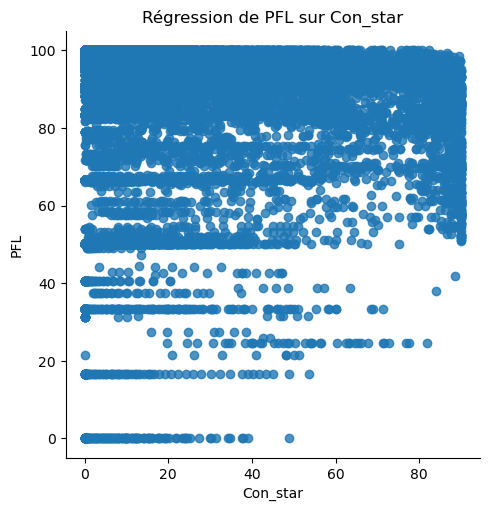

In [17]:
import seaborn as sns

# Tracer le nuage de points avec la ligne de régression ajustée
sns.lmplot(x='Con_star', y='PFL', data=df.reset_index(), ci=None)
plt.xlabel('Con_star')
plt.ylabel('PFL')
plt.title('Régression de PFL sur Con_star')
plt.show()

## 2nd step

Maintenant qu'on a identifié $\hat{\phi}^{i}_{t}$. On cherche à vérifier l'équation suivante : 

\begin{equation}
{\phi}^{i}_{t} = \frac{1}{c^{i}_{\phi}} (P^{i} - A^{i}(E^{i}_{t} - {\Psi}^{i}_{t}))
\end{equation}

\begin{equation}
\Leftrightarrow \Delta{\phi}^{i}_{t} = \frac{1}{c^{i}_{\phi}} ( - A^{i}(\Delta E^{i}_{t} - \Delta{\Psi}^{i}_{t}))
\end{equation}

\begin{equation}
\Leftrightarrow \Delta{\phi}^{i}_{t} = \frac{ - A^{i}}{c^{i}_{\phi}} (\Delta E^{i}_{t} - \Delta{\Psi}^{i}_{t})
\end{equation}

Or, on suppose que la valeur environnemental fondamentale d'une entreprise ne varie que très peu d'un mois à l'autre : $\Delta{\Psi}^{i}_{t} \sim \epsilon_{t}$ où $\epsilon_{t}$ est un bruit blanc. Ainsi

\begin{equation}
\Leftrightarrow \Delta{\phi}^{i}_{t} = {\alpha}_i + \Delta E^{i}_{t} + {\epsilon}^{i}_{t}
\end{equation}

En corrigeant l'endogénéité de $E^{i}_{t}$, on obtient : 

\begin{equation}
\Leftrightarrow {\phi}^{i}_{t} = {\alpha}_{3,1}^{i} + {\beta}_3 E^{i,*}_{t-1} + {\eta}^{i}_{1,t}
\end{equation}

### 1ère étape : Construction de ESG_star

In [18]:
df['ESG_lag'] = df.groupby(level=0)['ESG'].shift(1)

df

score_comm        ESG         PFL    Diff_z  \
idEntreprise Date                                                      
1            2009-01-01   -0.015203  60.866464  100.000000  5.475597   
             2009-02-01   -0.014819  61.046910  100.000000  5.339223   
             2009-03-01   -0.009638  61.223748  100.000000  5.534291   
             2009-04-01   -0.019162  60.841493  100.000000  5.639993   
             2009-05-01   -0.019016  60.590206  100.000000  5.892612   
...                             ...        ...         ...       ...   
18386        2022-12-01   -0.316436  49.680590   99.219927  2.391562   
             2023-01-01   -0.312305  49.648089   99.219927  2.386211   
             2023-02-01   -0.311182  49.616238   99.219927  2.347607   
             2023-03-01   -0.315421  49.585025   99.219927  2.344902   
             2023-04-01   -0.318254  50.109991   99.219927  1.663395   

                         Controverse  \
idEntreprise Date                      
1            2009-01-01    29.837788   
             2009-02-01    23.870230   
             2009-03-01    19.096184   
             2009-04-01    26.388059   
             2009-05-01    43.332669   
...                              ...   
18386        2022-12-01     0.278300   
             2023-01-01     0.222640   
             2023-02-01     0.178112   
             2023-03-01     0.142490   
             2023-04-01     0.113992   

                                                    GICS industry group  \
idEntreprise Date                                                         
1            2009-01-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-02-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-03-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-04-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-05-01  Pharmaceuticals, Biotechnology & Life Sciences   
...                                                                 ...   
18386        2022-12-01                              Financial Services   
             2023-01-01                              Financial Services   
             2023-02-01                              Financial Services   
             2023-03-01                              Financial Services   
             2023-04-01                              Financial Services   

                           GICS sub-industry    Con_lag   Con_star  Rep_2SLS  \
idEntreprise Date                                                              
1            2009-01-01      Pharmaceuticals        NaN        NaN       NaN   
             2009-02-01      Pharmaceuticals  29.837788  26.860962 -1.963438   
             2009-03-01      Pharmaceuticals  23.870230  21.488769 -1.570751   
             2009-04-01      Pharmaceuticals  19.096184  17.191015 -1.256601   
             2009-05-01      Pharmaceuticals  26.388059  23.755401 -1.736433   
...                                      ...        ...        ...       ...   
18386        2022-12-01  Specialized Finance   0.347875   0.313169 -0.022891   
             2023-01-01  Specialized Finance   0.278300   0.250535 -0.018313   
             2023-02-01  Specialized Finance   0.222640   0.200428 -0.014651   
             2023-03-01  Specialized Finance   0.178112   0.160342 -0.011720   
             2023-04-01  Specialized Finance   0.142490   0.128274 -0.009376   

                         epsilon_hat   phi_hat    ESG_lag  
idEntreprise Date                                          
1            2009-01-01          NaN       NaN        NaN  
             2009-02-01    34.529597       NaN  60.866464  
             2009-03-01    32.696721 -1.832876  61.046910  
             2009-04-01    31.472761 -1.223960  61.223748  
             2009-05-01    31.848970  0.376209  60.841493  
...                              ...       ...        ...  
18386        2022-12-01    43.352229  0.106026  49.713754  
          

In [19]:
# Première étape: Régression de ESG sur ESG_lag avec effets fixes
stage_one = PanelOLS(dependent=df['ESG'], 
                       exog=df[['ESG_lag']],
                       entity_effects=True, 
                       time_effects=True)
res_stage_one = stage_one.fit()

# Ajouter les valeurs ajustées à df
df['ESG_star'] = res_stage_one.fitted_values

df

score_comm        ESG         PFL    Diff_z  \
idEntreprise Date                                                      
1            2009-01-01   -0.015203  60.866464  100.000000  5.475597   
             2009-02-01   -0.014819  61.046910  100.000000  5.339223   
             2009-03-01   -0.009638  61.223748  100.000000  5.534291   
             2009-04-01   -0.019162  60.841493  100.000000  5.639993   
             2009-05-01   -0.019016  60.590206  100.000000  5.892612   
...                             ...        ...         ...       ...   
18386        2022-12-01   -0.316436  49.680590   99.219927  2.391562   
             2023-01-01   -0.312305  49.648089   99.219927  2.386211   
             2023-02-01   -0.311182  49.616238   99.219927  2.347607   
             2023-03-01   -0.315421  49.585025   99.219927  2.344902   
             2023-04-01   -0.318254  50.109991   99.219927  1.663395   

                         Controverse  \
idEntreprise Date                      
1            2009-01-01    29.837788   
             2009-02-01    23.870230   
             2009-03-01    19.096184   
             2009-04-01    26.388059   
             2009-05-01    43.332669   
...                              ...   
18386        2022-12-01     0.278300   
             2023-01-01     0.222640   
             2023-02-01     0.178112   
             2023-03-01     0.142490   
             2023-04-01     0.113992   

                                                    GICS industry group  \
idEntreprise Date                                                         
1            2009-01-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-02-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-03-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-04-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-05-01  Pharmaceuticals, Biotechnology & Life Sciences   
...                                                                 ...   
18386        2022-12-01                              Financial Services   
             2023-01-01                              Financial Services   
             2023-02-01                              Financial Services   
             2023-03-01                              Financial Services   
             2023-04-01                              Financial Services   

                           GICS sub-industry    Con_lag   Con_star  Rep_2SLS  \
idEntreprise Date                                                              
1            2009-01-01      Pharmaceuticals        NaN        NaN       NaN   
             2009-02-01      Pharmaceuticals  29.837788  26.860962 -1.963438   
             2009-03-01      Pharmaceuticals  23.870230  21.488769 -1.570751   
             2009-04-01      Pharmaceuticals  19.096184  17.191015 -1.256601   
             2009-05-01      Pharmaceuticals  26.388059  23.755401 -1.736433   
...                                      ...        ...        ...       ...   
18386        2022-12-01  Specialized Finance   0.347875   0.313169 -0.022891   
             2023-01-01  Specialized Finance   0.278300   0.250535 -0.018313   
             2023-02-01  Specialized Finance   0.222640   0.200428 -0.014651   
             2023-03-01  Specialized Finance   0.178112   0.160342 -0.011720   
             2023-04-01  Specialized Finance   0.142490   0.128274 -0.009376   

                         epsilon_hat   phi_hat    ESG_lag   ESG_star  
idEntreprise Date                                                     
1            2009-01-01          NaN       NaN        NaN        NaN  
             2009-02-01    34.529597       NaN  60.866464  60.292582  
             2009-03-01    32.696721 -1.832876  61.046910  60.471327  
             2009-04-01    31.472761 -1.223960  61.223748  60.646498  
             2009-05-01    31.848970  0.376209  60.841493  60.267847  
...                              ...       ...       

#### Analyse de ESG_star et de sa régression

In [20]:
print(res_stage_one)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    ESG   R-squared:                        0.9805
Estimator:                   PanelOLS   R-squared (Between):              0.9999
No. Observations:               16929   R-squared (Within):               0.9823
Date:                Fri, May 03 2024   R-squared (Overall):              0.9998
Time:                        07:47:54   Log-likelihood                -1.813e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                    8.36e+05
Entities:                          99   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(1,16659)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):           8.36e+05
                            

Voici une explication des principaux éléments de la sortie :

    R-squared : Le coefficient de détermination indique la proportion de la variance de la variable dépendante (ESG) expliquée par le modèle. Dans ce cas, le R² est de 0.9679, ce qui signifie que le modèle explique environ 96.79% de la variance de ESG.

    F-statistic : Il s'agit de la statistique F associée au test d'omnibus pour la significativité globale du modèle. Ici, la statistique F est de 3.592e+05 avec une p-valeur de 0.0000, ce qui suggère que le modèle dans son ensemble est extrêmement statistiquement significatif.

    Parameter Estimates : Cette section présente les estimations des paramètres du modèle. Dans ce cas, le coefficient associé à la variable ESG_lag est estimé à 0.9885. Cela signifie que pour une augmentation d'une unité de ESG_lag, la variable Controverse augmente en moyenne de 0.9885 unités.

    F-test for Poolability : Il s'agit du test de significativité pour l'effet fixe des entités et des périodes de temps. La p-valeur associée est de 0.0000, ce qui suggère que l'effet fixe est statistiquement significatif.

    Included effects : Cela indique les effets inclus dans le modèle. Dans ce cas, les effets fixe des entités et des périodes de temps sont inclus.

Globalement, les résultats suggèrent que le modèle est extrêmement significatif, et la variable ESG_lag a un effet positif significatif sur la variable Controverse après avoir contrôlé les effets fixes des entités et des périodes de temps.

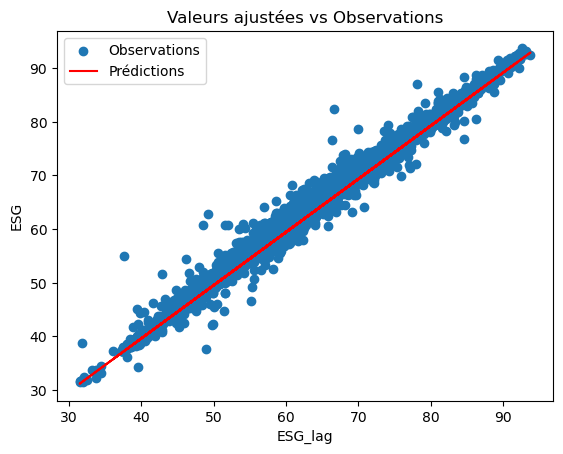

In [21]:
plt.scatter(df['ESG_lag'], df['ESG'], label='Observations')
plt.plot(df['ESG_lag'], df['ESG_star'], color='red', label='Prédictions')
plt.xlabel('ESG_lag')
plt.ylabel('ESG')
plt.legend()
plt.title('Valeurs ajustées vs Observations')
plt.show()

In [22]:
# Créer un modèle RandomEffects
random_effects_model = RandomEffects(df['ESG'], df[['ESG_lag']])

# Ajuster le modèle
res_random_effects = random_effects_model.fit()

# Comparer les estimations des effets fixes et des effets aléatoires
hausman_test = compare({'Effets Fixes': res_stage_one, 'Effets Aléatoires': res_random_effects})
print(hausman_test)

                    Model Comparison                    
                          Effets Fixes Effets Aléatoires
--------------------------------------------------------
Dep. Variable                      ESG               ESG
Estimator                     PanelOLS     RandomEffects
No. Observations                 16929             16929
Cov. Est.                   Unadjusted        Unadjusted
R-squared                       0.9805            0.9998
R-Squared (Within)              0.9823            0.9822
R-Squared (Between)             0.9999            1.0000
R-Squared (Overall)             0.9998            0.9999
F-statistic                   8.36e+05         8.367e+07
P-value (F-stat)                0.0000            0.0000
=====================     ============   ===============
ESG_lag                         0.9906            1.0007
                              (914.33)          (9146.9)
======================= ============== =================
Effects                        

### 2nde étape : Regression de phi_hat sur ESG_star

In [23]:
df['ESG_star_shift'] = df['ESG_star'].shift(1)
df['Delta_phi_hat'] = df.groupby('idEntreprise')['phi_hat'].diff()
df['Delta_ESG_star_shift'] = df.groupby('idEntreprise')['ESG_star_shift'].diff()
df

score_comm        ESG         PFL    Diff_z  \
idEntreprise Date                                                      
1            2009-01-01   -0.015203  60.866464  100.000000  5.475597   
             2009-02-01   -0.014819  61.046910  100.000000  5.339223   
             2009-03-01   -0.009638  61.223748  100.000000  5.534291   
             2009-04-01   -0.019162  60.841493  100.000000  5.639993   
             2009-05-01   -0.019016  60.590206  100.000000  5.892612   
...                             ...        ...         ...       ...   
18386        2022-12-01   -0.316436  49.680590   99.219927  2.391562   
             2023-01-01   -0.312305  49.648089   99.219927  2.386211   
             2023-02-01   -0.311182  49.616238   99.219927  2.347607   
             2023-03-01   -0.315421  49.585025   99.219927  2.344902   
             2023-04-01   -0.318254  50.109991   99.219927  1.663395   

                         Controverse  \
idEntreprise Date                      
1            2009-01-01    29.837788   
             2009-02-01    23.870230   
             2009-03-01    19.096184   
             2009-04-01    26.388059   
             2009-05-01    43.332669   
...                              ...   
18386        2022-12-01     0.278300   
             2023-01-01     0.222640   
             2023-02-01     0.178112   
             2023-03-01     0.142490   
             2023-04-01     0.113992   

                                                    GICS industry group  \
idEntreprise Date                                                         
1            2009-01-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-02-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-03-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-04-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-05-01  Pharmaceuticals, Biotechnology & Life Sciences   
...                                                                 ...   
18386        2022-12-01                              Financial Services   
             2023-01-01                              Financial Services   
             2023-02-01                              Financial Services   
             2023-03-01                              Financial Services   
             2023-04-01                              Financial Services   

                           GICS sub-industry    Con_lag   Con_star  Rep_2SLS  \
idEntreprise Date                                                              
1            2009-01-01      Pharmaceuticals        NaN        NaN       NaN   
             2009-02-01      Pharmaceuticals  29.837788  26.860962 -1.963438   
             2009-03-01      Pharmaceuticals  23.870230  21.488769 -1.570751   
             2009-04-01      Pharmaceuticals  19.096184  17.191015 -1.256601   
             2009-05-01      Pharmaceuticals  26.388059  23.755401 -1.736433   
...                                      ...        ...        ...       ...   
18386        2022-12-01  Specialized Finance   0.347875   0.313169 -0.022891   
             2023-01-01  Specialized Finance   0.278300   0.250535 -0.018313   
             2023-02-01  Specialized Finance   0.222640   0.200428 -0.014651   
             2023-03-01  Specialized Finance   0.178112   0.160342 -0.011720   
             2023-04-01  Specialized Finance   0.142490   0.128274 -0.009376   

                         epsilon_hat   phi_hat    ESG_lag   ESG_star  \
idEntreprise Date                                                      
1            2009-01-01          NaN       NaN        NaN        NaN   
             2009-02-01    34.529597       NaN  60.866464  60.292582   
             2009-03-01    32.696721 -1.832876  61.046910  60.471327   
             2009-04-01    31.472761 -1.223960  61.223748  60.646498   
             2009-05-01    31.848970  0.376209  60.841493  60.267847   
...                              ...       ...

In [24]:
# Seconde étape: Régression de phi_hat sur ESG instrumenté par ESG_star avec effets fixes
stage_two_fix = PanelOLS(dependent=df['Delta_phi_hat'], 
                        exog=df[['Delta_ESG_star_shift']],
                        entity_effects=True, 
                        time_effects=False)
res_stage_two_fix = stage_two_fix.fit()

##### Analyse de la regression :

In [25]:
print(res_stage_two_fix)

                          PanelOLS Estimation Summary                           
Dep. Variable:          Delta_phi_hat   R-squared:                        0.0007
Estimator:                   PanelOLS   R-squared (Between):             -0.1552
No. Observations:               16731   R-squared (Within):               0.0007
Date:                Fri, May 03 2024   R-squared (Overall):              0.0007
Time:                        07:47:57   Log-likelihood                -4.488e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      11.339
Entities:                          99   P-value                           0.0008
Avg Obs:                       169.00   Distribution:                 F(1,16631)
Min Obs:                       169.00                                           
Max Obs:                       169.00   F-statistic (robust):             11.339
                            

-----------------------------------------------------------------------------------------------------------------------------
Voici une explication des principaux éléments de la sortie :

    R-squared (R-carré):
Le R-carré est une mesure de l'ajustement du modèle aux données. Ici, le R-carré est très faible, indiquant que le modèle n'explique qu'une très faible proportion de la variance de la variable dépendante.

    F-statistic (Statistique F):
La statistique F est utilisée pour tester la significativité globale du modèle. Dans ce cas, la valeur de la statistique F est faible, ce qui suggère que le modèle global n'est pas statistiquement significatif.

    Parameter Estimates (Estimations des paramètres):
Pour la variable ESG_star_shift, le coefficient estimé est de 0.0043 avec un écart-type de 0.0038. Cependant, le test de significativité t (T-stat) montre que ce coefficient n'est pas statistiquement significatif à un niveau de confiance de 95 %, car le p-valeur associé est supérieur à 0,05.

    F-test for Poolability (Test F pour la poolabilité):
Ce test évalue la pertinence d'inclure les effets d'entité dans le modèle. Ici, le p-valeur associé au test est supérieur à 0,05, ce qui suggère que l'inclusion des effets d'entité n'est pas statistiquement significative.

    Included Effects (Effets inclus):
Seuls les effets d'entité sont inclus dans le modèle. Cela signifie que le modèle prend en compte les différences systématiques entre les différentes entités de l'échantillon.

En résumé, le modèle PanelOLS n'explique pas de manière significative la variance de la variable dépendante phi_hat, et aucun des coefficients des variables indépendantes n'est statistiquement significatif. De plus, l'inclusion des effets d'entité dans le modèle n'est pas justifiée selon le test de poolabilité.

De même ici, on a de meilleurs résultats :)

# Extensions

### Modèle à retards distribués

In [26]:
df_mult_lag = pd.read_pickle('data_pannels.pkl')
df_mult_lag['Date'] = pd.to_datetime(df_mult_lag['Date'])
df_mult_lag['ESG'] = df_mult_lag['ESG'].str.replace(',', '.').astype(float)
df_mult_lag.set_index(['idEntreprise', 'Date'], inplace=True)

max_lags_con = 1  # A ajuster selon les besoins

# Générer les variables laggées
for lag in range(1, max_lags_con + 1):
    df_mult_lag[f'Con_lag{lag}'] = df_mult_lag.groupby(level=0)['Controverse'].shift(lag)

exog_vars = [f'Con_lag{lag}' for lag in range(1, max_lags_con + 1)]
df_mult_lag_exog = df_mult_lag[exog_vars]

# Regression avec fixed effects
mod = PanelOLS(dependent=df_mult_lag['Controverse'], exog=df_mult_lag_exog, entity_effects=True, time_effects=True)
res = mod.fit()
df_mult_lag['Con_star_fix'] = res.fitted_values

# Second stage: Regression de PFL sur Con_star_fix avec fixed effects
second_stage_mult_lag = PanelOLS(dependent=df_mult_lag['PFL'], exog=df_mult_lag[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage_mult_lag = second_stage_mult_lag.fit()

# Ajouter fitted values et residuals 
df_mult_lag['Rep_2SLS'] = res_second_stage_mult_lag.fitted_values
df_mult_lag['epsilon_hat'] = res_second_stage_mult_lag.resids

# Calcul du proxy du flux de communication environnementale
df_mult_lag['phi_hat'] = df_mult_lag.groupby(level=0)['epsilon_hat'].diff()

# Output the results
#res_second_stage_mult_lag

max_lags_esg = 4

# Generate lagged variables for ESG
for lag in range(1, max_lags_esg + 1):
    df_mult_lag[f'ESG_lag{lag}'] = df_mult_lag.groupby(level=0)['ESG'].shift(lag)

# Select exogenous variables for the model
exog_vars = [f'ESG_lag{lag}' for lag in range(1, max_lags_esg + 1)]
df_mult_lag_exog = df_mult_lag[exog_vars]

# First stage: Regression of ESG on multiple lagged ESG with fixed effects
first_stage = PanelOLS(dependent=df_mult_lag['ESG'], exog=df_mult_lag_exog, entity_effects=True, time_effects=True)
res_first_stage = first_stage.fit()

# Add the fitted values to the dataframe
df_mult_lag['ESG_star'] = res_first_stage.fitted_values

# Shift ESG_star for use in the second stage
df_mult_lag['ESG_star_shift'] = df_mult_lag['ESG_star'].shift(1)

# Second stage: Regression of phi_hat on shifted ESG_star
second_stage = PanelOLS(dependent=df_mult_lag['phi_hat'], exog=df_mult_lag[['ESG_star_shift']], entity_effects=True, time_effects=False)
res_second_stage = second_stage.fit()

# Output the results
res_second_stage

Dep. Variable:,phi_hat,R-squared:,0.0001
Estimator:,PanelOLS,R-squared (Between):,-4.3903
No. Observations:,16533,R-squared (Within):,0.0001
Date:,"Fri, May 03 2024",R-squared (Overall):,-0.0165
Time:,07:48:05,Log-likelihood,-3.833e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2.0120
Entities:,99,P-value,0.1561
Avg Obs:,167.00,Distribution:,"F(1,16433)"
Min Obs:,167.00,,
Max Obs:,167.00,F-statistic (robust):,2.0120


In [27]:
df_mult_lag = pd.read_pickle('data_pannels.pkl')
df_mult_lag['Date'] = pd.to_datetime(df_mult_lag['Date'])
df_mult_lag['ESG'] = df_mult_lag['ESG'].str.replace(',', '.').astype(float)
df_mult_lag.set_index(['idEntreprise', 'Date'], inplace=True)

# Essayer tous les lags possibles pour 'ESG' et 'Con'
max_possible_lags = 10
best_r2 = -1
total_iterations = max_possible_lags ** 2

with tqdm(total=total_iterations, desc="Optimizing lags") as pbar:
    for max_lags_con in range(1, max_possible_lags + 1):
        for max_lags_esg in range(1, max_possible_lags + 1):

            # Màj barre de progression
            pbar.update(1)

            # Générer les variables laggées pour 'Con'
            for lag in range(1, max_lags_con + 1):
                df_mult_lag[f'Con_lag{lag}'] = df_mult_lag.groupby(level=0)['Controverse'].shift(lag)
            exog_vars_con = [f'Con_lag{lag}' for lag in range(1, max_lags_con + 1)]
            df_mult_lag_exog_con = df_mult_lag[exog_vars_con]

            # Regression avec fixed effects pour 'Con'
            mod_con = PanelOLS(dependent=df_mult_lag['Controverse'], exog=df_mult_lag_exog_con, entity_effects=True, time_effects=True)
            res_con = mod_con.fit()
            df_mult_lag['Con_star_fix'] = res_con.fitted_values

            # Second stage: Regression de PFL sur Con_star_fix avec fixed effects
            second_stage_mult_lag = PanelOLS(dependent=df_mult_lag['PFL'], exog=df_mult_lag[['Con_star_fix']], entity_effects=True, time_effects=True)
            res_second_stage_mult_lag = second_stage_mult_lag.fit()
            df_mult_lag['epsilon_hat'] = res_second_stage_mult_lag.resids
            df_mult_lag['phi_hat'] = df_mult_lag.groupby(level=0)['epsilon_hat'].diff()

            # Générer les variables laggées pour 'ESG'
            for lag in range(1, max_lags_esg + 1):
                df_mult_lag[f'ESG_lag{lag}'] = df_mult_lag.groupby(level=0)['ESG'].shift(lag)
            exog_vars_esg = [f'ESG_lag{lag}' for lag in range(1, max_lags_esg + 1)]
            df_mult_lag_exog_esg = df_mult_lag[exog_vars_esg]

            # First stage: Regression de ESG sur les multiple lagged ESG avec fixed effects
            first_stage = PanelOLS(dependent=df_mult_lag['ESG'], exog=df_mult_lag_exog_esg, entity_effects=True, time_effects=True)
            res_first_stage = first_stage.fit()
            df_mult_lag['ESG_star'] = res_first_stage.fitted_values
            df_mult_lag['ESG_star_shift'] = df_mult_lag['ESG_star'].shift(1)

            # Second stage: Regression de phi_hat sur shifted ESG_star
            second_stage = PanelOLS(dependent=df_mult_lag['phi_hat'], exog=df_mult_lag[['ESG_star_shift']], entity_effects=True, time_effects=False)
            res_second_stage = second_stage.fit()

            # Choisir le meilleur R-squared
            if res_second_stage.rsquared > best_r2:
                best_r2 = res_second_stage.rsquared
                best_lags_con = max_lags_con
                best_lags_esg = max_lags_esg

print(f'Best R-squared: {best_r2} achieved with {best_lags_con} lags for Con and {best_lags_esg} lags for ESG')

Optimizing lags: 100%|██████████| 100/100 [11:47<00:00,  7.08s/it]

Best R-squared: 0.00028672686308284234 achieved with 1 lags for Con and 1 lags for ESG


### Variables instrumentales multiples

On rajoute ici comme instrument la moyenne laggée des controverses des autres entreprises de même secteur.

In [28]:
# Load the data
df_mult_lag = pd.read_pickle('data_pannels.pkl')
df_mult_lag['Date'] = pd.to_datetime(df_mult_lag['Date'])
df_mult_lag['ESG'] = df_mult_lag['ESG'].str.replace(',', '.').astype(float)
df_mult_lag.set_index(['idEntreprise', 'Date'], inplace=True)

df_mult_lag

score_comm        ESG         PFL    Diff_z  \
idEntreprise Date                                                      
1            2009-01-01   -0.015203  60.866464  100.000000  5.475597   
             2009-02-01   -0.014819  61.046910  100.000000  5.339223   
             2009-03-01   -0.009638  61.223748  100.000000  5.534291   
             2009-04-01   -0.019162  60.841493  100.000000  5.639993   
             2009-05-01   -0.019016  60.590206  100.000000  5.892612   
...                             ...        ...         ...       ...   
18386        2022-12-01   -0.316436  49.680590   99.219927  2.391562   
             2023-01-01   -0.312305  49.648089   99.219927  2.386211   
             2023-02-01   -0.311182  49.616238   99.219927  2.347607   
             2023-03-01   -0.315421  49.585025   99.219927  2.344902   
             2023-04-01   -0.318254  50.109991   99.219927  1.663395   

                         Controverse  \
idEntreprise Date                      
1            2009-01-01    29.837788   
             2009-02-01    23.870230   
             2009-03-01    19.096184   
             2009-04-01    26.388059   
             2009-05-01    43.332669   
...                              ...   
18386        2022-12-01     0.278300   
             2023-01-01     0.222640   
             2023-02-01     0.178112   
             2023-03-01     0.142490   
             2023-04-01     0.113992   

                                                    GICS industry group  \
idEntreprise Date                                                         
1            2009-01-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-02-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-03-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-04-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-05-01  Pharmaceuticals, Biotechnology & Life Sciences   
...                                                                 ...   
18386        2022-12-01                              Financial Services   
             2023-01-01                              Financial Services   
             2023-02-01                              Financial Services   
             2023-03-01                              Financial Services   
             2023-04-01                              Financial Services   

                           GICS sub-industry  
idEntreprise Date                             
1            2009-01-01      Pharmaceuticals  
             2009-02-01      Pharmaceuticals  
             2009-03-01      Pharmaceuticals  
             2009-04-01      Pharmaceuticals  
             2009-05-01      Pharmaceuticals  
...                                      ...  
18386        2022-12-01  Specialized Finance  
             2023-01-01  Specialized Finance  
             2023-02-01  Specialized Finance  
             2023-03-01  Specialized Finance  
             2023-04-01  Specialized Finance  

[17028 rows x 7 columns]

In [29]:
nombre_entreprises = df.index.get_level_values('idEntreprise').nunique()
print("Nombre d'entreprises dans la DataFrame :", nombre_entreprises)

Nombre d'entreprises dans la DataFrame : 99


In [30]:
from datetime import datetime

# Dates de début et de fin
date_debut = datetime(2009, 1, 1)
date_fin = datetime(2023, 4, 30)

# Calcul de la différence en mois
difference_mois = (date_fin.year - date_debut.year) * 12 + date_fin.month - date_debut.month + 1

print("Nombre de mois entre janvier 2009 et avril 2023 inclus :", difference_mois)

Nombre de mois entre janvier 2009 et avril 2023 inclus : 172


In [31]:
# Compter le nombre de secteurs différents et leur fréquence
secteur_counts = df_mult_lag['GICS industry group'].value_counts() / 172

# Compter le nombre de sous-secteurs différents et leur fréquence
sous_secteur_counts = df_mult_lag['GICS sub-industry'].value_counts() / 172

# Calculer la moyenne des fréquences des secteurs et des sous-secteurs
moyenne_secteurs = secteur_counts.mean()
moyenne_sous_secteurs = sous_secteur_counts.mean()

# Calculer la médiane des fréquences des secteurs et des sous-secteurs
median_secteurs = secteur_counts.median()
median_sous_secteurs = sous_secteur_counts.median()

print("Nombre de secteurs différents :", len(secteur_counts))
print("Fréquence des secteurs :")
print(secteur_counts)
print("\nMoyenne des fréquences des secteurs :", moyenne_secteurs)
print("Médiane des fréquences des secteurs :", median_secteurs, "\n")

print('--'*50)

print("\n  Nombre de sous-secteurs différents :", len(sous_secteur_counts))
print("Fréquence des sous-secteurs :")
print(sous_secteur_counts)
print("\n Moyenne des fréquences des sous-secteurs :", moyenne_sous_secteurs)
print("Médiane des fréquences des sous-secteurs :", median_sous_secteurs)

Nombre de secteurs différents : 21
Fréquence des secteurs :
GICS industry group
Materials                                         11.0
Capital Goods                                      9.0
Energy                                             8.0
Food, Beverage & Tobacco                           8.0
Banks                                              8.0
Automobiles & Components                           7.0
Utilities                                          6.0
Financial Services                                 6.0
Pharmaceuticals, Biotechnology & Life Sciences     5.0
Telecommunication Services                         4.0
Transportation                                     4.0
Consumer Services                                  3.0
Media & Entertainment                              3.0
Software & Services                                3.0
Technology Hardware & Equipment                    3.0
Insurance                                          2.0
Consumer Staples Distribution & Retail  

On observe qu'en moyenne, il y a 4 entreprises par secteurs, contre seulement 1 entreprises par sous secteur dans notre base de données => difficile d'introduire le sous secteur dans la régression

In [32]:
# Calculate the sector average lagged controversy score
df_mult_lag['Sector_Con_lag1'] = df_mult_lag.groupby(['GICS industry group', pd.Grouper(level='Date')])['Controverse'].transform(lambda x: x.shift(1).mean())

# Generate lagged variables for controversy
df_mult_lag['Con_lag1'] = df_mult_lag.groupby(level=0)['Controverse'].shift(1)

# Define exogenous variables including the new sector-based instrument
exog_vars = ['Con_lag1', 'Sector_Con_lag1']

# First stage: Regression of Controversy on lagged controversy and sector average controversy
mod = PanelOLS(dependent=df_mult_lag['Controverse'], exog=df_mult_lag[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit()
df_mult_lag['Con_star_fix'] = res.fitted_values

# Second stage: Regression of PFL on instrumented Con_star_fix
second_stage = PanelOLS(dependent=df_mult_lag['PFL'], exog=df_mult_lag[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage = second_stage.fit()
df_mult_lag['Rep_2SLS'] = res_second_stage.fitted_values
df_mult_lag['epsilon_hat'] = res_second_stage.resids

# Calculate the proxy for environmental communication flow
df_mult_lag['phi_hat'] = df_mult_lag.groupby(level=0)['epsilon_hat'].diff()

# Generate lagged variables for ESG
df_mult_lag['ESG_lag'] = df_mult_lag.groupby(level=0)['ESG'].shift(1)

# Second stage: Regression of phi_hat on shifted ESG_star using the lagged ESG as an instrument
first_stage_esg = PanelOLS(dependent=df_mult_lag['ESG'], exog=df_mult_lag[['ESG_lag']], entity_effects=True, time_effects=True)
res_first_stage_esg = first_stage_esg.fit()
df_mult_lag['ESG_star'] = res_first_stage_esg.fitted_values
df_mult_lag['ESG_star_shift'] = df_mult_lag['ESG_star'].shift(1)

df_mult_lag['Delta_phi_hat'] = df_mult_lag.groupby('idEntreprise')['phi_hat'].diff()
df_mult_lag['Delta_ESG_star_shift'] = df_mult_lag.groupby('idEntreprise')['ESG_star_shift'].diff()

second_stage_phi = PanelOLS(dependent=df_mult_lag['Delta_phi_hat'], exog=df_mult_lag[['Delta_ESG_star_shift']], entity_effects=True, time_effects=False)
res_second_stage_phi = second_stage_phi.fit()

print(res_second_stage_phi)

                          PanelOLS Estimation Summary                           
Dep. Variable:          Delta_phi_hat   R-squared:                        0.0006
Estimator:                   PanelOLS   R-squared (Between):             -0.1467
No. Observations:               16562   R-squared (Within):               0.0006
Date:                Fri, May 03 2024   R-squared (Overall):              0.0006
Time:                        08:00:01   Log-likelihood                -4.441e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      10.576
Entities:                          98   P-value                           0.0011
Avg Obs:                       169.00   Distribution:                 F(1,16463)
Min Obs:                       169.00                                           
Max Obs:                       169.00   F-statistic (robust):             10.576
                            

#### Pertinence de l'instrument

In [33]:
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.8138
Estimator:                   PanelOLS   R-squared (Between):              0.9898
No. Observations:               16758   R-squared (Within):               0.8457
Date:                Fri, May 03 2024   R-squared (Overall):              0.9549
Time:                        07:59:56   Log-likelihood                 -5.63e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.604e+04
Entities:                          98   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(2,16488)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):          3.604e+04
                            

On voit bien que les T-stat et la F-stat sont suffisement élevées, ce qui nous comforte dans la pertinence de notre nouvel instrument. 

On rajoute maintenant les sous-secteurs.

-----
_____

In [34]:
# Supposons que 'df_mult_lag' a déjà les colonnes 'GICS industry group' et 'GICS sub-industry'

# Calculer la moyenne laggée de controverse par sous-secteur
df_mult_lag['Subsector_Con_lag1'] = df_mult_lag.groupby(['GICS sub-industry', pd.Grouper(level='Date')])['Controverse'].transform(lambda x: x.shift(1).mean())

# Ajouter la nouvelle variable instrumentale aux variables exogènes
exog_vars = ['Con_lag1', 'Sector_Con_lag1', 'Subsector_Con_lag1']  # Mise à jour des variables exogènes

# Régression de la première étape avec les nouveaux instruments
mod = PanelOLS(dependent=df_mult_lag['Controverse'], exog=df_mult_lag[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit()
df_mult_lag['Con_star_fix'] = res.fitted_values

# Deuxième étape : Régression de 'PFL' sur 'Con_star_fix'
second_stage = PanelOLS(dependent=df_mult_lag['PFL'], exog=df_mult_lag[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage = second_stage.fit()
df_mult_lag['Rep_2SLS'] = res_second_stage.fitted_values
df_mult_lag['epsilon_hat'] = res_second_stage.resids

# Calcul du flux de communication environnementale
df_mult_lag['phi_hat'] = df_mult_lag.groupby(level=0)['epsilon_hat'].diff()

# Régression de la deuxième étape pour 'phi_hat' sur 'ESG_star_shift'
second_stage_phi_sub = PanelOLS(dependent=df_mult_lag['phi_hat'], exog=df_mult_lag[['ESG_star_shift']], entity_effects=True, time_effects=False)
res_second_stage_phi_sub = second_stage_phi_sub.fit()

print(res_second_stage_phi_sub)


                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):             -24.610
No. Observations:               10540   R-squared (Within):               0.0005
Date:                Fri, May 03 2024   R-squared (Overall):             -0.0758
Time:                        08:00:09   Log-likelihood                -2.492e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5.6135
Entities:                          62   P-value                           0.0178
Avg Obs:                       170.00   Distribution:                 F(1,10477)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             5.6135
                            

On regarde la pertinence:

In [35]:
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.8246
Estimator:                   PanelOLS   R-squared (Between):              0.9900
No. Observations:               10602   R-squared (Within):               0.8565
Date:                Fri, May 03 2024   R-squared (Overall):              0.9585
Time:                        08:00:06   Log-likelihood                -3.585e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.625e+04
Entities:                          62   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(3,10367)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):          1.625e+04
                            

Voici une petite visualisation:

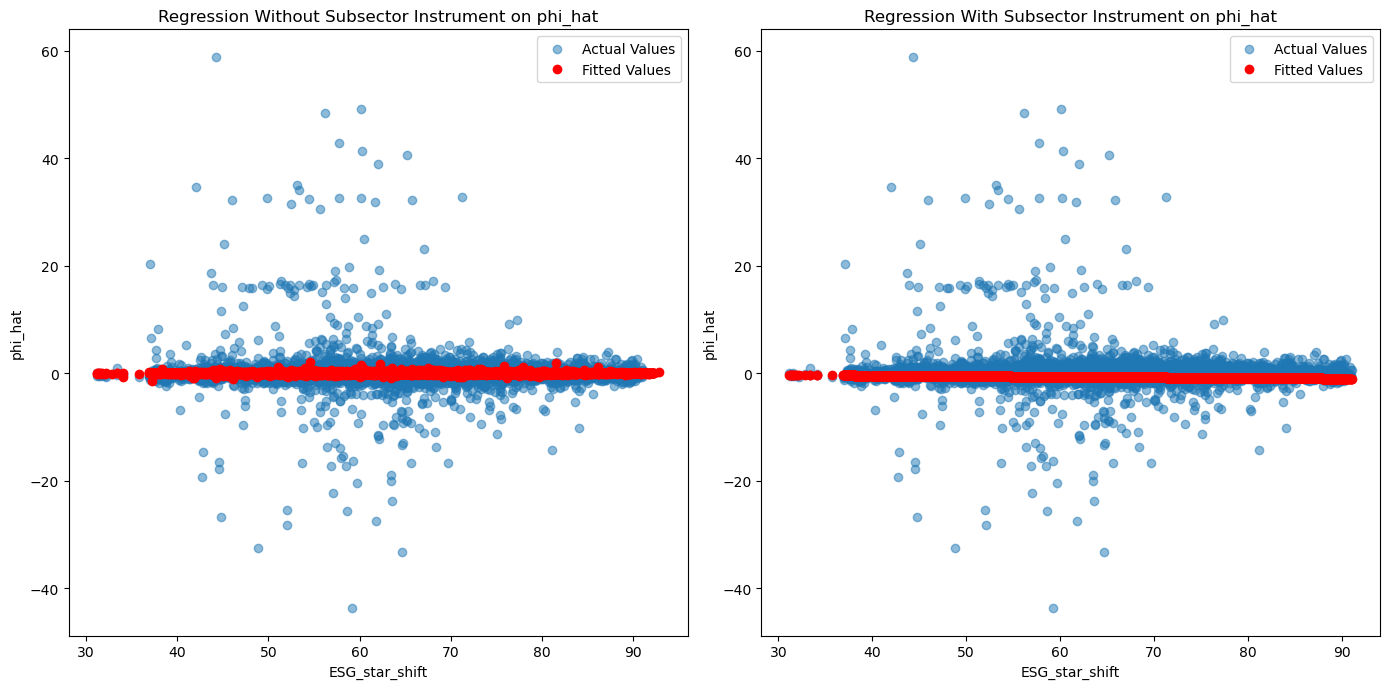

In [36]:
# Extract the fitted values from the second stage regressions correctly
df_mult_lag['phi_hat_fitted_without_subsector'] = res_second_stage_phi.fitted_values  
df_mult_lag['phi_hat_fitted_with_subsector'] = res_second_stage_phi_sub.fitted_values   

# Plot for the regression without subsector as an instrument
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(df_mult_lag['ESG_star_shift'], df_mult_lag['phi_hat'], alpha=0.5, label='Actual Values')
plt.plot(df_mult_lag['ESG_star_shift'], df_mult_lag['phi_hat_fitted_without_subsector'], 'o', color='red', label='Fitted Values')
plt.title('Regression Without Subsector Instrument on phi_hat')
plt.xlabel('ESG_star_shift')
plt.ylabel('phi_hat')
plt.legend()

# Plot for the regression with subsector as an instrument
plt.subplot(1, 2, 2)
plt.scatter(df_mult_lag['ESG_star_shift'], df_mult_lag['phi_hat'], alpha=0.5, label='Actual Values')
plt.plot(df_mult_lag['ESG_star_shift'], df_mult_lag['phi_hat_fitted_with_subsector'], 'o', color='red', label='Fitted Values')
plt.title('Regression With Subsector Instrument on phi_hat')
plt.xlabel('ESG_star_shift')
plt.ylabel('phi_hat')
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
model_comparison = compare({"Without Subsector": res_second_stage_phi, "With Subsector": res_second_stage_phi_sub})
print("\nDetailed Model Comparison:")
print(model_comparison)



Detailed Model Comparison:
                     Model Comparison                    
                         Without Subsector With Subsector
---------------------------------------------------------
Dep. Variable                Delta_phi_hat        phi_hat
Estimator                         PanelOLS       PanelOLS
No. Observations                     16562          10540
Cov. Est.                       Unadjusted     Unadjusted
R-squared                           0.0006         0.0005
R-Squared (Within)                  0.0006         0.0005
R-Squared (Between)                -0.1467        -24.610
R-Squared (Overall)                 0.0006        -0.0758
F-statistic                         10.576         5.6135
P-value (F-stat)                    0.0011         0.0178
======================     ===============   ============
Delta_ESG_star_shift                0.1246               
                                  (3.2520)               
ESG_star_shift                              

_____
_____

### Une autre modélisation pour la relation entre Le score de réputation et le score de controverse

Si on revient sur la régression en deux étapes du score de réputation sur le score de controverse (lui même régressé sur le score de controverse précédent), on observe que la première régression semble significative (la controverse d'hier semble expliquer en grande partie celle d'aujourd'hui). En revanche, la seconde régression semble plutôt mauvaise, avec un R2 très faible, et une statistique de test pour la variable trop faible également. On essaye donc de trouver un autre modèle qui pourrait mieux fitter les données. Dans un premier temps, on essaie de visualiser les données

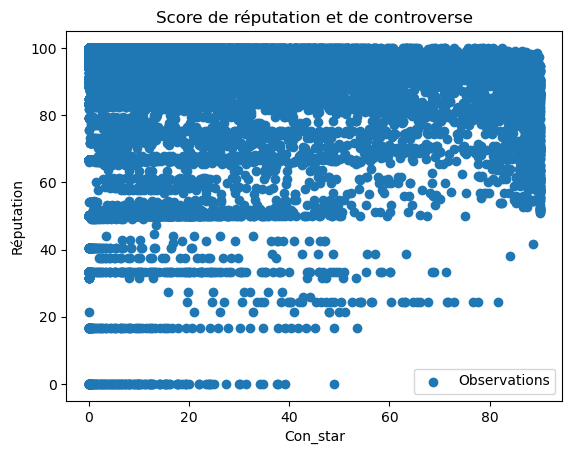

In [38]:
plt.scatter(df['Con_star'], df['PFL'], label='Observations')
plt.xlabel('Con_star')
plt.ylabel('Réputation')
plt.legend()
plt.title('Score de réputation et de controverse')
plt.show()

Difficile de voir quelque chose... Tire 10 entreprises au hasard, et on observe l'évolution de leur score de réputation et de controverse au fil du temps

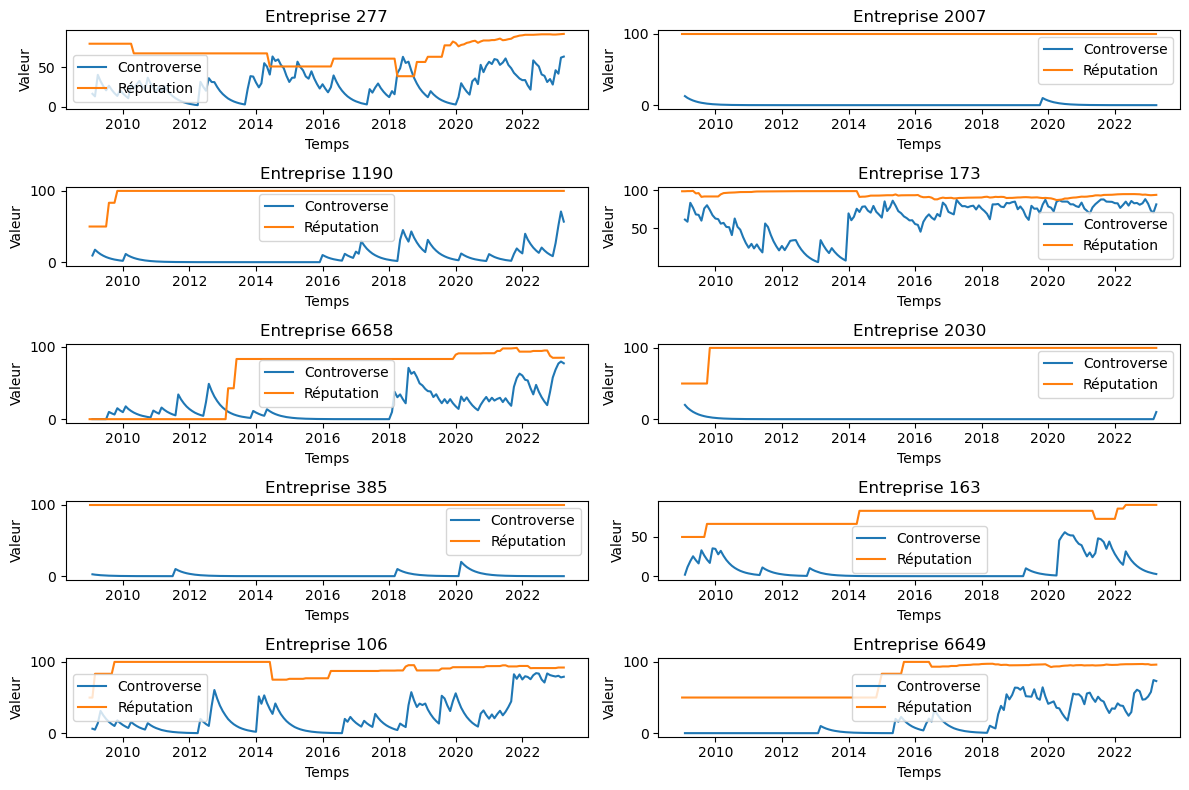

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Définir le nombre d'entreprises à afficher
nombre_entreprises = 10  # Vous pouvez ajuster ce nombre selon vos besoins

# Sélection aléatoire de plusieurs entreprises
entreprises_aleatoires = np.random.choice(df.index.get_level_values('idEntreprise').unique(), size=nombre_entreprises, replace=False)

# Calculer le nombre de lignes et de colonnes nécessaires pour la grille
nb_lignes = (nombre_entreprises + 1) // 2  # Une ligne supplémentaire pour gérer les cas impairs
nb_colonnes = 2

# Créer une nouvelle figure pour la grille de graphiques
fig, axs = plt.subplots(nb_lignes, nb_colonnes, figsize=(12, 8))

# Parcourir chaque entreprise et tracer son graphique dans la grille
for i, entreprise_aleatoire in enumerate(entreprises_aleatoires):
    # Filtrer les données pour l'entreprise choisie
    donnees_entreprise = df.loc[entreprise_aleatoire]

    # Calculer les coordonnées dans la grille
    ligne = i // nb_colonnes
    colonne = i % nb_colonnes

    # Créer un graphique sur les axes correspondants
    ax = axs[ligne, colonne]

    # Tracer la courbe pour Con_star
    ax.plot(donnees_entreprise.index.get_level_values('Date'), donnees_entreprise['Con_star'], label='Controverse')

    # Tracer la courbe pour PFL (Réputation)
    ax.plot(donnees_entreprise.index.get_level_values('Date'), donnees_entreprise['PFL'], label='Réputation')

    # Ajouter des étiquettes d'axe et un titre
    ax.set_xlabel('Temps')
    ax.set_ylabel('Valeur')
    ax.set_title(f'Entreprise {entreprise_aleatoire}')

    # Afficher la légende
    ax.legend()

# Ajuster automatiquement les espacements entre les sous-graphiques
plt.tight_layout()

# Afficher la grille de graphiques
plt.show()

L'observation de ces graphiques nous fait réaliser qu'une relation linéaire entre le score de controverse, et le score de réputation, semble peu plausible. On propose donc de rajouter dans la régression, la possibilité d'effets quadratiques ou logarithmiques :

### Amélioration de la régression de phi_hat sur ESG_star

On peut partir du principe qu'il pourrait exister un effet temps sur la variable de communication verte. Avec le temps, les entreprises, soucieuses de leur cours en bourse par exemple, ou encore de satisfaire le besoin environnemental de leur client, cherchent à communiquer de plus en plus vert. On essaye d'améliorer le modèle en incluant un effet temps :

In [40]:
# Seconde étape: Régression de phi_hat sur ESG instrumenté par ESG_star avec effets fixes et effet dans le temps
stage_two_fix_time = PanelOLS(dependent=df['phi_hat'], 
                        exog=df[['ESG_star_shift']],
                        entity_effects=True, 
                        time_effects=True)
res_stage_two_fix_time = stage_two_fix_time.fit()

print(res_stage_two_fix_time)

                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):             -15.124
No. Observations:               16830   R-squared (Within):               0.0003
Date:                Fri, May 03 2024   R-squared (Overall):             -0.0514
Time:                        08:00:15   Log-likelihood                -3.944e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5.4459
Entities:                          99   P-value                           0.0196
Avg Obs:                       170.00   Distribution:                 F(1,16561)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             5.4459
                            

La stat de Fischer, tout comme la p-value du test de student, semble s'être améliorer !

In [41]:
# Seconde étape: Régression de phi_hat sur ESG instrumenté par ESG_star avec effets fixes et effet dans le temps
stage_two_random_time = PanelOLS(dependent=df['phi_hat'], 
                        exog=df[['ESG_star_shift']],
                        entity_effects=False, 
                        time_effects=True)
res_stage_two_random_time = stage_two_random_time.fit()

print(res_stage_two_random_time)

                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):             -3.6612
No. Observations:               16830   R-squared (Within):               0.0002
Date:                Fri, May 03 2024   R-squared (Overall):             -0.0123
Time:                        08:00:17   Log-likelihood                -3.946e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.2439
Entities:                          99   P-value                           0.0041
Avg Obs:                       170.00   Distribution:                 F(1,16659)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             8.2439
                            

### Autre modèle pour prédire $\phi$ : Le clustering

#### Justification de la démarche :

Les trois principaux avantages du clustering (face à la régression linéaire :)

    Détection des structures non linéaires : Contrairement à la régression linéaire, qui suppose une relation linéaire entre les variables, le clustering peut identifier des structures non linéaires dans les données. Cela permet d'explorer des relations plus complexes entre les variables.

    Identification des groupes similaires : Le clustering permet d'identifier des groupes d'observations similaires dans les données, même lorsque les relations entre les variables ne sont pas clairement définies. Cela peut être utile pour segmenter les données en fonction de caractéristiques communes, ce qui peut faciliter l'analyse et la prise de décision.

    Interprétation des résultats : Le clustering produit des groupes d'observations similaires, ce qui peut faciliter l'interprétation des résultats. Par exemple, vous pouvez identifier des segments de clients ayant des comportements similaires dans un contexte marketing ou des clusters d'entreprises ayant des profils similaires dans un contexte financier.

#### Application du modèle de clustering :

In [42]:
df1 = df[['ESG', 'PFL', 'Diff_z', 'Controverse']]
df1 = df1.reset_index(drop=False)
df1

,idEntreprise,Date,ESG,PFL,Diff_z,Controverse
0,1,2009-01-01,60.866464,100.000000,5.475597,29.837788
1,1,2009-02-01,61.046910,100.000000,5.339223,23.870230
2,1,2009-03-01,61.223748,100.000000,5.534291,19.096184
3,1,2009-04-01,60.841493,100.000000,5.639993,26.388059
4,1,2009-05-01,60.590206,100.000000,5.892612,43.332669
...,...,...,...,...,...,...
17023,18386,2022-12-01,49.680590,99.219927,2.391562,0.278300
17024,18386,2023-01-01,49.648089,99.219927,2.386211,0.222640
17025,18386,2023-02-01,49.616238,99.219927,2.347607,0.178112
17026,18386,2023-03-01,49.585025,99.219927,2.344902,0.142490


In [43]:
import pandas as pd
from sklearn.cluster import KMeans

# Définir les fenêtres temporelles (par exemple, chaque année)
time_windows = pd.date_range(start=df1['Date'].min(), 
                             end=df1['Date'].max(), 
                             freq='YE')

# Initialiser un dictionnaire pour stocker les modèles de clustering
cluster_models = {}

# Calculer les statistiques agrégées et entraîner les modèles de clustering pour chaque fenêtre temporelle
for i, window_end in enumerate(time_windows):
    if i == 0:
        continue  # Ignorer la première fenêtre temporelle car il n'y a pas de données précédentes pour calculer les différences
        
    # Sélectionner les données dans la fenêtre temporelle actuelle
    window_data = df1[df1['Date'] <= window_end]
    
    # Vérifier si des données sont disponibles dans la fenêtre temporelle
    if window_data.empty:
        print(f"Aucune donnée disponible dans la fenêtre temporelle jusqu'à : {window_end}")
        continue
    
    # Calculer les statistiques agrégées pour chaque entreprise
    agg_data = window_data.groupby('idEntreprise')[['PFL', 'Controverse']].mean()
    
    # Créer un objet KMeans avec le nombre de clusters souhaité
    kmeans = KMeans(n_clusters=3)
    
    # Entraîner le modèle de clustering sur les données agrégées
    kmeans.fit(agg_data)
    
    # Stocker le modèle de clustering dans le dictionnaire
    cluster_models[window_end] = kmeans
    
# Prédire les clusters pour chaque entreprise à une date spécifique
def predict_clusters_at_date(date):
    for window_end, kmeans in cluster_models.items():
        if date <= window_end:
            print(f"Sélection du modèle de clustering pour la date : {date}")
            # Sélectionner les données agrégées pour la date spécifique
            agg_data_date = df1[df1['Date'] == date].groupby('idEntreprise')[['PFL', 'Controverse']].mean()
            # Prédire les clusters pour les données agrégées de la date spécifique
            predicted_cluster_labels = kmeans.predict(agg_data_date)
            
            # Créer un dictionnaire pour stocker les indices des entreprises par cluster
            clusters = {}
            for i, label in enumerate(predicted_cluster_labels):
                if label not in clusters:
                    clusters[label] = []
                clusters[label].append(agg_data_date.index[i])
                
            return clusters

In [44]:
# Exemple d'utilisation : afficher les entreprises dans le même cluster pour une date spécifique
clusters = predict_clusters_at_date(pd.Timestamp('2019-01-01'))

# Créer les tables de données pour chaque cluster
tables_cluster = {}
nombre_de_donnees_par_table = {}

for cluster, entreprises in clusters.items():
    # Sélectionner les lignes des entreprises dans le cluster actuel
    entreprises_cluster = df1[df1['idEntreprise'].isin(entreprises)]
    # Stocker la table de données pour ce cluster
    tables_cluster[cluster] = entreprises_cluster
    # Calculer le nombre de données dans cette table
    nombre_de_donnees_par_table[cluster] = len(entreprises_cluster)

# Afficher les tables de données et le nombre de données pour chaque cluster
for cluster, table in tables_cluster.items():
    print(f"Cluster {cluster}:")
    print(table)
    print(f"Nombre de données dans la table : {nombre_de_donnees_par_table[cluster]}")
    print(f"Nombre d'entreprises dans le cluster : {nombre_de_donnees_par_table[cluster] / 172}\n")  # Nombre d'entreprises = nombre de données / 172

Sélection du modèle de clustering pour la date : 2019-01-01 00:00:00
Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01
...             ...        ...        ...    ...       ...           ...
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09

[9460 rows x 6 columns]
Nombre de données d

#### Choix optimal du nombre de cluster

Il existe différentes méthodes qui permettent de connaître le nombre de cluster optimal à demander à l'algorithme. En voici 3

##### Méthode du coude

La méthode du coude (Elbow Method en anglais) est une technique couramment utilisée pour déterminer le nombre optimal de clusters dans un algorithme de clustering, tel que K-Means. L'idée fondamentale est de rechercher le nombre de clusters qui explique le mieux la variance dans les données, tout en évitant la surajustement.

Voici comment fonctionne la méthode du coude :

    Inertie : L'inertie, également connue sous le nom de somme des distances au carré des échantillons à leur centre de cluster le plus proche, mesure la variance intra-cluster. En d'autres termes, elle quantifie la dispersion des points de données à l'intérieur de chaque cluster. Une faible inertie indique que les points à l'intérieur de chaque cluster sont très proches de leur centre de cluster, ce qui est souhaitable.

    Nombre de clusters : L'objectif est de choisir le nombre de clusters qui réduit l'inertie tout en évitant de créer un nombre excessif de clusters qui pourraient surajuster les données.

    Recherche du point de coude : Pour cela, vous exécutez l'algorithme de clustering pour différents nombres de clusters (par exemple, de 1 à N), et pour chaque nombre de clusters, vous calculez l'inertie correspondante.

    Visualisation : Ensuite, vous tracez un graphique du nombre de clusters par rapport à l'inertie. Vous recherchez le point sur le graphique où la courbe commence à fléchir comme le coude d'un bras. Ce point indique généralement le nombre optimal de clusters. Plus précisément, il représente le nombre de clusters où l'ajout d'un autre cluster ne réduit pas significativement l'inertie.

    Choix du nombre optimal de clusters : Vous choisissez le nombre de clusters à ce point de coude sur le graphique.

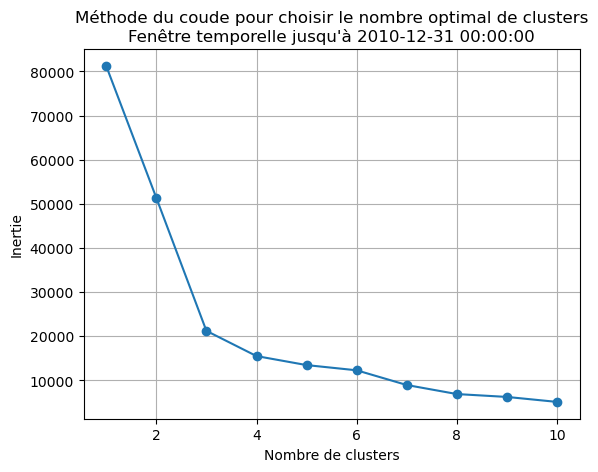

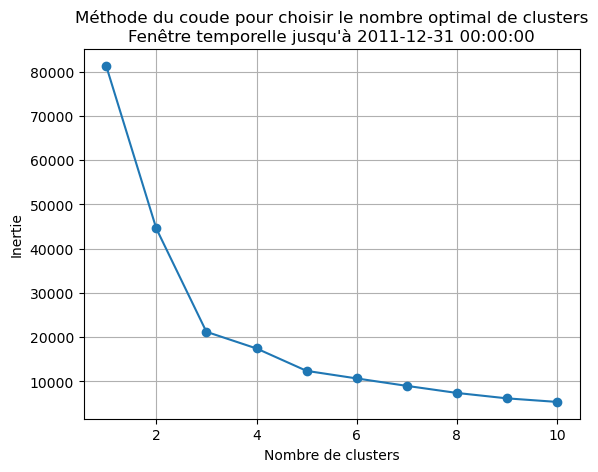

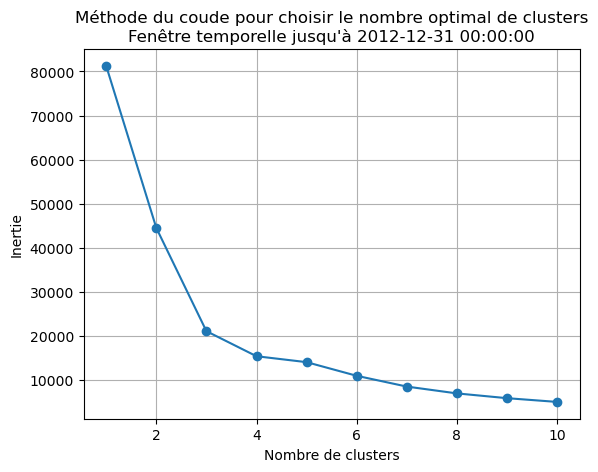

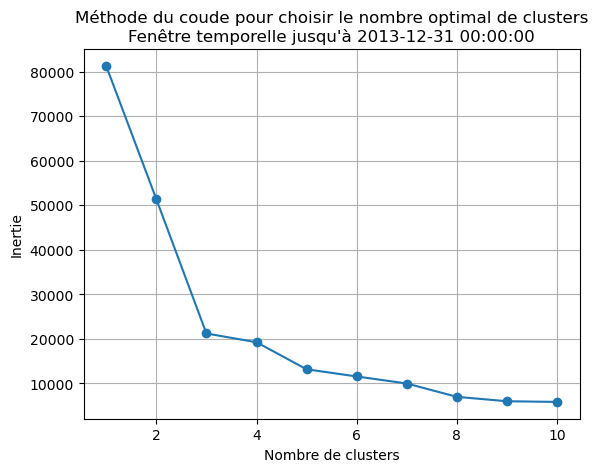

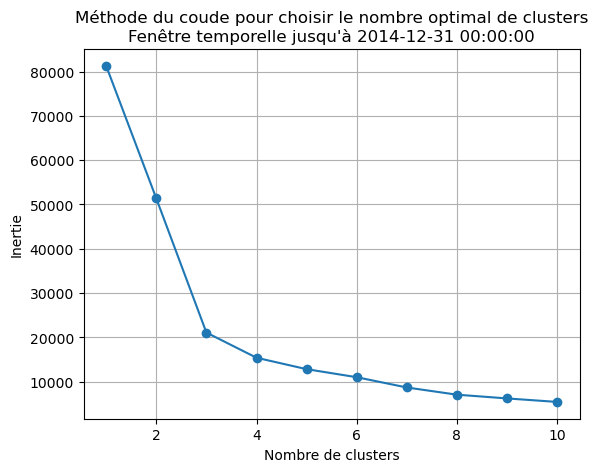

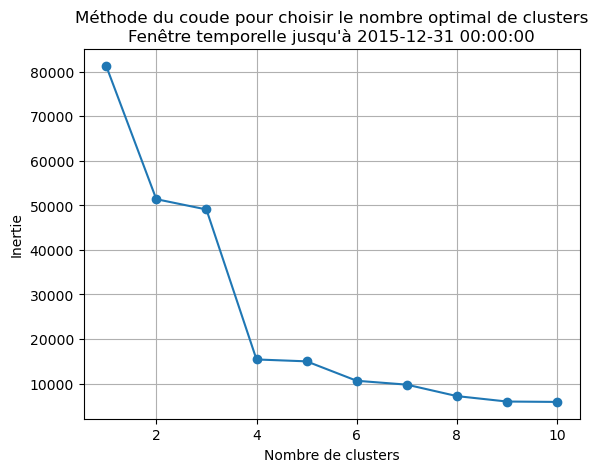

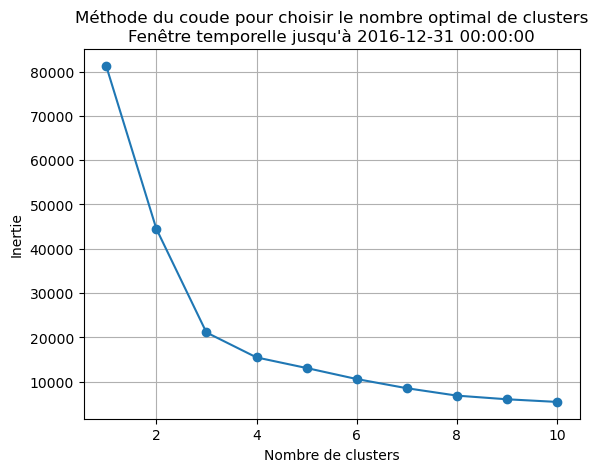

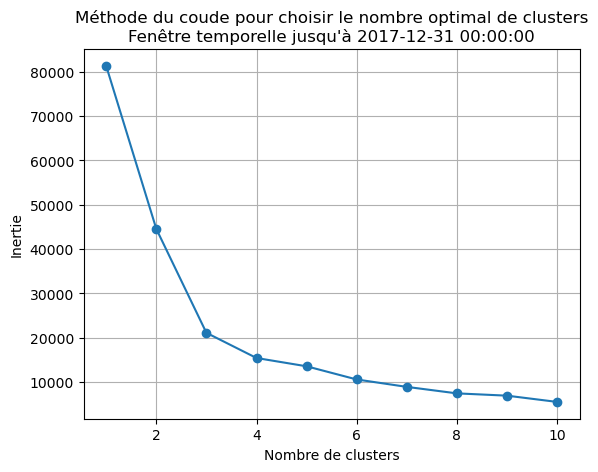

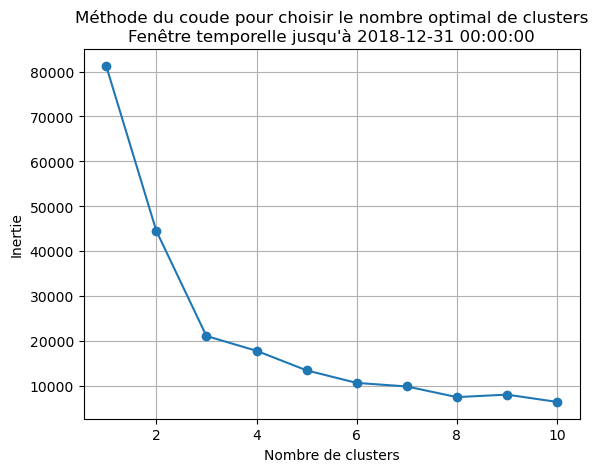

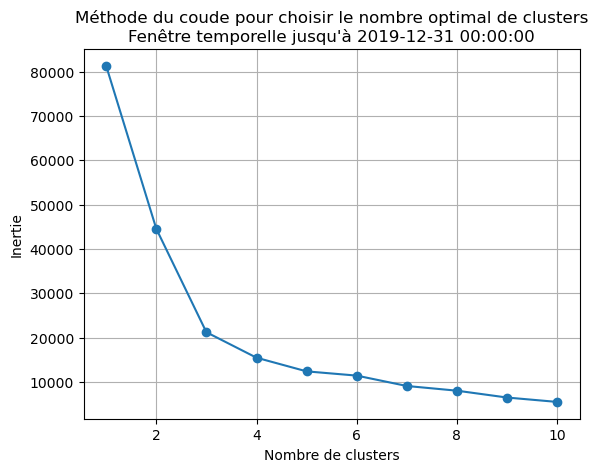

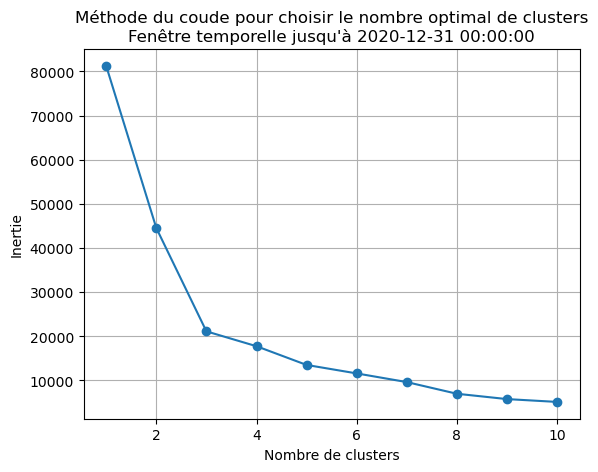

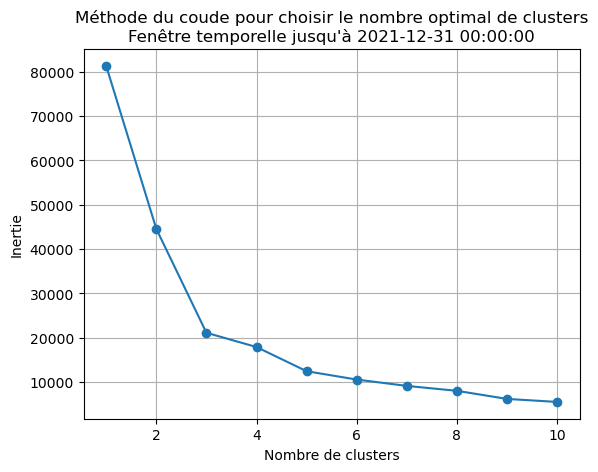

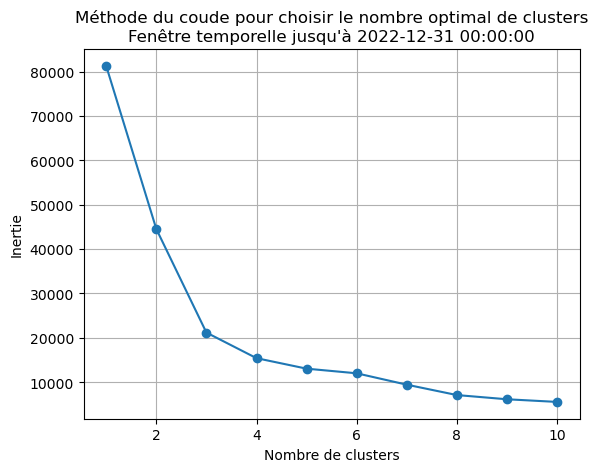

In [45]:
# Parcourir chaque modèle de clustering et trouver le meilleur k pour chaque fenêtre temporelle
for window_end, kmeans in cluster_models.items():
    agg_data = window_data.groupby('idEntreprise')[['PFL', 'Controverse']].mean()
    max_k = 10  # Définir le nombre maximal de clusters à tester
    inertias = []  # Liste pour stocker les inertias
    
    # Tester différents nombres de clusters (de 1 à max_k)
    for k in range(1, max_k + 1):
        # Créer un nouvel objet KMeans avec le nombre de clusters k
        kmeans_test = KMeans(n_clusters=k)
        # Entraîner le modèle de clustering sur les données agrégées
        kmeans_test.fit(agg_data)
        # Calculer l'inertie pour ce nombre de clusters
        inertia = kmeans_test.inertia_
        inertias.append(inertia)
    
    # Afficher le graphique de la méthode du coude pour choisir le nombre optimal de clusters
    plt.plot(range(1, max_k + 1), inertias, marker='o')
    plt.title(f"Méthode du coude pour choisir le nombre optimal de clusters\nFenêtre temporelle jusqu'à {window_end}")
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.grid(True)
    plt.show()

Résultat flagrant : il faut prendre k = 3 pour tout les modèles

##### Méthode de la silouhette

La méthode de la silhouette est une technique d'évaluation de la qualité des clusters dans un algorithme de clustering. Elle mesure à quel point chaque point de données est similaire à son propre cluster (cohésion) par rapport aux autres clusters (séparation). En d'autres termes, elle permet de déterminer à quel point les clusters sont bien séparés les uns des autres.

Voici les étapes de la méthode de la silhouette :

    Calcul des distances intra-cluster (a) : Pour chaque point de données dans un cluster, calculez la distance moyenne entre ce point et tous les autres points du même cluster. Cela mesure à quel point le point est proche des autres points de son propre cluster.

    Calcul des distances inter-cluster (b) : Pour chaque point de données dans un cluster, calculez la distance moyenne entre ce point et tous les points des clusters voisins les plus proches. Cela mesure à quel point le point est éloigné des points des autres clusters.

    Calcul de la silhouette (s) : Pour chaque point de données, calculez la silhouette comme suit :
        Calculez la différence entre la distance moyenne intra-cluster (a) et la distance moyenne inter-cluster (b).
        Divisez cette différence par le maximum des deux distances (max(a, b)).
        La silhouette pour chaque point de données est donc (b - a) / max(a, b).

    Calcul de la silhouette moyenne : Calculez la silhouette moyenne pour tous les points de données d'un cluster. Cela donne une mesure globale de la qualité du clustering. La silhouette moyenne est comprise entre -1 et 1. Un score élevé indique que les clusters sont bien séparés, tandis qu'un score proche de zéro indique que les clusters se chevauchent.

In [46]:
import matplotlib.pyplot as plt

# Parcourir chaque modèle de clustering et trouver le meilleur k pour chaque fenêtre temporelle
for window_end, kmeans in cluster_models.items():
    agg_data = window_data.groupby('idEntreprise')[['PFL', 'Controverse']].mean()
    max_k = 10  # Définir le nombre maximal de clusters à tester
    silhouette_scores = []  # Liste pour stocker les scores de silhouette
    
    # Tester différents nombres de clusters (de 2 à max_k)
    for k in range(2, max_k + 1):
        # Créer un nouvel objet KMeans avec le nombre de clusters k
        kmeans_test = KMeans(n_clusters=k)
        # Entraîner le modèle de clustering sur les données agrégées
        kmeans_test.fit(agg_data)
        # Calculer le score de silhouette pour ce nombre de clusters
        silhouette_avg = silhouette_score(agg_data, kmeans_test.labels_)
        silhouette_scores.append(silhouette_avg)
    
    # Afficher le graphique du score de silhouette en fonction du nombre de clusters
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.title(f"Score de silhouette en fonction du nombre de clusters pour la fenêtre temporelle jusqu'à {window_end}")
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score de silhouette')
    plt.grid(True)
    plt.show()

NameError: name 'silhouette_score' is not defined

Résultat flagrant : il faut prendre k = 3 pour tout les modèles

##### Score de Calinski-Harabasz

Le score de Calinski-Harabasz, également appelé critère de variance, est une mesure de la qualité d'un clustering. Il évalue la compacité intra-cluster par rapport à la séparation inter-cluster. En d'autres termes, il mesure à quel point les clusters sont compacts et bien séparés les uns des autres.

Voici comment le score de Calinski-Harabasz est calculé :

    Calcul de la dispersion intra-cluster : Pour chaque cluster, calculez la dispersion intra-cluster, qui est la somme des carrés des distances entre chaque point de données du cluster et le centre de ce cluster (généralement le centroïde).

    Calcul de la dispersion inter-cluster : Calculez la dispersion inter-cluster, qui est la somme des carrés des distances entre les centres des clusters et le centre global de tous les points de données.

    Calcul du score de Calinski-Harabasz : Le score est calculé en divisant la dispersion intra-cluster par la dispersion inter-cluster, puis en multipliant le résultat par le nombre de clusters moins un (k - 1).

In [ ]:
# Initialiser un dictionnaire pour stocker les scores de Calinski-Harabasz pour chaque fenêtre temporelle
ch_scores = {}

# Parcourir chaque modèle de clustering et trouver le meilleur k pour chaque fenêtre temporelle
for window_end, kmeans in cluster_models.items():
    agg_data = window_data.groupby('idEntreprise')[['PFL', 'Controverse']].mean()
    max_k = 10  # Définir le nombre maximal de clusters à tester
    ch_scores[window_end] = []  # Initialiser une liste pour stocker les scores de Calinski-Harabasz
    
    # Tester différents nombres de clusters (de 2 à max_k)
    for k in range(2, max_k + 1):
        # Créer un nouvel objet KMeans avec le nombre de clusters k
        kmeans_test = KMeans(n_clusters=k)
        # Entraîner le modèle de clustering sur les données agrégées
        kmeans_test.fit(agg_data)
        # Calculer le score de Calinski-Harabasz pour ce nombre de clusters
        ch_score = calinski_harabasz_score(agg_data, kmeans_test.labels_)
        ch_scores[window_end].append(ch_score)

# Afficher les graphiques des scores de Calinski-Harabasz en fonction du nombre de clusters pour chaque modèle
for window_end, scores in ch_scores.items():
    plt.plot(range(2, max_k + 1), scores, marker='o')
    plt.title(f"Score de Calinski-Harabasz en fonction du nombre de clusters\nFenêtre temporelle jusqu'à {window_end}")
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score de Calinski-Harabasz')
    plt.grid(True)
    plt.show()

##### Conclusion : k = 3

Les méthodes du coude et de la silhouette montre que prendre k=3 est optimal pour tout les modèles de clusters. Le Score de Calinski-Harabasz lui est moins tranché, et propose des clusters à k=9 voir k=10. On prendra par soucis de simplicité k=3

#### Affichage des cluster pour la prédiction de 2019-01-01

In [ ]:
df_cluster_1 = tables_cluster[0]
df_cluster_1

In [ ]:
df_cluster_2 = tables_cluster[1]
df_cluster_2

In [ ]:
df_cluster_3 = tables_cluster[2]
df_cluster_3

Maintenant qu'on est capable d'identifier des groupes d'entreprises homogènes pour une période donnée, comment savoir quels groupe a une forte ou faible communication environnemental ? 

Au lieu de prendre le score de communication environemental comme une variable quantitative, on la garde comme variable qualitative. Avec 3 niveaux de communication : 

Niveau 0 => faible communication

Niveau 1 => communication moyenne

Niveau 2 => forte communication

On pourra ensuite faire des régressions sur variables qualitatives => tout autre modèle. 

Seulement, comment attriber ces niveaux aux 3 clusters ? On prends la moyenne score Diff_z (qui représente le risque de greenwashing) par cluster, et on augmente la note de communication si la moyenne est élevé ? On pourrait peut être faire mieux encore, parce que le score Diff_z ne se base que sur les réputations, on pourrait inclure la controverse dans notre système d'attribution de note de communication environnemental.

Dans un premier temps, on va dire qu'on calcul la moyenne des différences entre le score de réputation et de controverse, entre 2009-01-01 et une date futur (date d'estimation du score de communication environnemental). Le cluster qui aura la moyenne la plus haute (ie avec un score de réputation élevé, et un score de controverse faible), représentera des entreprises qui sont bien vus, et aura la communication verte la plus faible (car pas besoin de communiquer, donc on va pas jetter de l'argent par les fenêtres)

In [ ]:
# Définir une fonction pour calculer la moyenne de la différence entre PFL et Controverse jusqu'à une date future spécifiée
def calculate_mean_difference(df_cluster):
    # Convertir la colonne "Date" en format datetime en utilisant .loc pour éviter l'avertissement SettingWithCopyWarning
    df_cluster.loc[:, 'Date'] = pd.to_datetime(df_cluster['Date'])

    # Spécifier la date future
    date_future = "2023-04-01"

    # Filtrer les données pour inclure uniquement les dates comprises entre le 1er janvier 2009 et la date future spécifiée
    filtered_data = df_cluster[(df_cluster['Date'] >= '2009-01-01') & (df_cluster['Date'] <= date_future)].copy()

    # Calculer la différence entre les colonnes "PFL" et "Controverse" en utilisant .loc pour éviter l'avertissement SettingWithCopyWarning
    filtered_data.loc[:, 'Difference'] = filtered_data['PFL'] - filtered_data['Controverse']

    # Calculer la moyenne de la différence
    mean_difference = filtered_data['Difference'].mean()

    print("Moyenne de la différence entre PFL et Controverse jusqu'à la date future spécifiée:", mean_difference)

    return mean_difference

# Définir une fonction pour attribuer les scores en fonction des moyennes de différence
def attribution_score(dictionnaire_score):
    # Ordonner le dictionnaire de score en fonction de la moyenne de la différence entre PFL et Controverse
    sorted_scores = sorted(dictionnaire_score.items(), key=lambda x: x[1], reverse=True)

    # Créer un dictionnaire pour stocker les scores attribués
    scores_attribues = {}

    # Attribuer les scores
    for idx, (cluster, _) in enumerate(sorted_scores):
        scores_attribues[cluster] = idx

    return scores_attribues

dictionnaire_score = {
    'Cluster 1': calculate_mean_difference(df_cluster_1),
    'Cluster 2': calculate_mean_difference(df_cluster_2),
    'Cluster 3': calculate_mean_difference(df_cluster_3)
}

scores_attribues = attribution_score(dictionnaire_score)
print("Scores attribués :", scores_attribues)


On a donc qu'au 1er avril 2023, les entreprises appartenant au cluster 1 sont celles qui communiquent le moins. Les entreprises appartenant au cluster 2 sont celles qui communiquent moyennement, et les entreprises appartenant au cluster 3 sont celles qui communiquent le plus. On essaye d'étendre ces résultats à toutes les périodes :

#### Généralisation du code

On répète cette méthode pour toutes les dates possibles, et ainsi récupérer un score de communication environemental pour chaque période :

In [ ]:
scored_rows = {}

# Exemple d'utilisation : afficher les entreprises dans le même cluster pour une date spécifique
def predict_clusters_at_date(date, cluster_models):
    clusters = {}
    for window_end, kmeans in cluster_models.items():
        if date <= window_end:
            # Sélectionner les données agrégées pour la date spécifique
            agg_data_date = df1[df1['Date'] == date].groupby('idEntreprise')[['PFL', 'Controverse']].mean()
            # Prédire les clusters pour les données agrégées de la date spécifique
            predicted_cluster_labels = kmeans.predict(agg_data_date)
            
            # Créer un dictionnaire pour stocker les indices des entreprises par cluster
            clusters = {}
            for i, label in enumerate(predicted_cluster_labels):
                if label not in clusters:
                    clusters[label] = []
                clusters[label].append(agg_data_date.index[i])
                
            return clusters

# Modifier la fonction create_tables_clusters pour ajouter une colonne "Score" à chaque table de données
def create_tables_clusters(clusters):
    tables_cluster = {}
    nombre_de_donnees_par_table = {}

    for cluster, entreprises in clusters.items():
        # Sélectionner les lignes des entreprises dans le cluster actuel
        entreprises_cluster = df1[df1['idEntreprise'].isin(entreprises)]
        # Ajouter une colonne "Score" initialisée à NaN
        entreprises_cluster['Score'] = np.nan
        # Stocker la table de données pour ce cluster
        tables_cluster[cluster] = entreprises_cluster
        # Calculer le nombre de données dans cette table
        nombre_de_donnees_par_table[cluster] = len(entreprises_cluster)

    return tables_cluster, nombre_de_donnees_par_table

# Définir une fonction pour calculer la moyenne de la différence entre PFL et Controverse jusqu'à une date future spécifiée
def calculate_mean_difference(df_cluster, date_future):
    # Convertir la colonne "Date" en format datetime en utilisant .loc pour éviter l'avertissement SettingWithCopyWarning
    df_cluster.loc[:, 'Date'] = pd.to_datetime(df_cluster['Date'])

    # Filtrer les données pour inclure uniquement les dates comprises entre le 1er janvier 2009 et la date future spécifiée
    filtered_data = df_cluster[(df_cluster['Date'] >= '2009-01-01') & (df_cluster['Date'] <= date_future)].copy()

    # Calculer la différence entre les colonnes "PFL" et "Controverse" en utilisant .loc pour éviter l'avertissement SettingWithCopyWarning
    filtered_data.loc[:, 'Difference'] = filtered_data['PFL'] - filtered_data['Controverse']

    # Calculer la moyenne de la différence
    mean_difference = filtered_data['Difference'].mean()

    return mean_difference

# Définir une fonction pour attribuer les scores en fonction des moyennes de différence
def attribution_score(dictionnaire_score):
    # Ordonner le dictionnaire de score en fonction de la moyenne de la différence entre PFL et Controverse
    sorted_scores = sorted(dictionnaire_score.items(), key=lambda x: x[1], reverse=True)

    # Créer un dictionnaire pour stocker les scores attribués
    scores_attribues = {}

    # Attribuer les scores
    for idx, (cluster, _) in enumerate(sorted_scores):
        scores_attribues[cluster] = idx

    return scores_attribues


# Spécifier les dates futures
dates_future = pd.date_range(start='2009-01-01', end='2022-12-01', freq='MS')

# Boucle sur toutes les dates futures
for date_future in dates_future:
    date_future_str = date_future.strftime('%Y-%m-%d')
    print(f"Date future: {date_future_str}")

    # Prédire les clusters pour la date spécifique
    clusters = predict_clusters_at_date(date_future, cluster_models)

    # Créer les tables de données pour chaque cluster avec la colonne "Score"
    tables_cluster, nombre_de_donnees_par_table = create_tables_clusters(clusters)

    # Calculer la moyenne de la différence pour chaque cluster
    mean_difference_per_cluster = {}
    for cluster, _ in clusters.items():
        df_cluster = tables_cluster[cluster]  # Accéder au DataFrame du cluster
        mean_difference_per_cluster[cluster] = calculate_mean_difference(df_cluster, date_future)

    # Attribuer les scores en fonction des moyennes de différence
    scores_per_cluster = attribution_score(mean_difference_per_cluster)

    # Créer les tables de données pour chaque cluster
    tables_cluster, nombre_de_donnees_par_table = create_tables_clusters(clusters)

    # Afficher les tables de données, le nombre de données et le score pour chaque cluster
    for cluster, table in tables_cluster.items():
    
        # Itérer sur chaque ligne du DataFrame du cluster
        for idx, row in table.iterrows():
            # Vérifier si la date de la ligne correspond à la date future
            if row['Date'] == date_future:
                # Attribuer le score à cette ligne
                table.at[idx, 'Score'] = scores_per_cluster[cluster]
                scored_rows[idx] = table.loc[idx]            

        print(f"Cluster {cluster}:")
        print(table)
        print(f"Nombre d'entreprises dans le cluster : {nombre_de_donnees_par_table[cluster] / 172}")  # Nombre d'entreprises = nombre de données / 172
        print(f"Score attribué : {scores_per_cluster[cluster]}\n")

scored_df = pd.DataFrame.from_dict(scored_rows, orient='index')
scored_df


In [ ]:
# Ordonner le DataFrame en fonction de la variable quantitative idEntreprise
scored_df_sorted = scored_df.sort_values(by=['idEntreprise', 'Date'])

# Afficher le DataFrame ordonné
scored_df_sorted

# Le reste du code

In [ ]:
def get_user_date(start_date, end_date):
    # Prompt the user for a date
    user_date_str = input(f"Enter a date between {start_date} and {end_date} (format YYYY-MM): ")
    
    # Convert user input to a pandas Timestamp
    try:
        user_date = pd.to_datetime(user_date_str, format='%Y-%m')
        start_date = pd.to_datetime(start_date, format='%Y-%m')
        end_date = pd.to_datetime(end_date, format='%Y-%m')

        # Check if the date is within the range
        if start_date <= user_date <= end_date:
            print(f"Selected date: {user_date.strftime('%Y-%m')}")
            return user_date
        else:
            print("Date is out of range. Please try again.")
            return None
    except ValueError:
        print("Invalid date format. Please try again.")
        return None

# Example usage
get_user_date("2002-01", "2023-04")


In [ ]:
# On laisse l'utilisateur choisir une date
date_debut="2002-01"
date_fin="2023-04"
t = get_user_date(date_debut,date_fin)
t = pd.to_datetime(t, format='%Y-%m')
t_minus_1 = (t - pd.DateOffset(months=1)).strftime('%Y-%m')
print(t_minus_1)

# On recupère les scores des etp aux dates t et t-1
col_index = esg_data.columns.get_loc(t)
esge_t = esg_data.iloc[:, col_index]
col_index = esg_data.columns.get_loc(t_minus_1)
esge_t_minus_1 = esg_data.iloc[:, col_index]

In [ ]:
data = {
    'env_comm_score': env_comm_score, 
    'esge': esge_t
    'esge_past': esge_t_minus_1
    'esge_peer': np.random.uniform(0, 100, 100)  # 100 peer environmental scores in the same sector
}

df = pd.DataFrame(data)

# Show the first few rows of the DataFrame
print(df.head())

# Define your variables
dependent = df['env_comm_score']
independent = df[['const']]  # Assuming you've added a constant term to your DataFrame
instrument = df['esge_past']  # Instrumenting esge with its past value
endogenous = df['esge']  # The variable you believe is endogenous

# Setup and run the 2SLS regression
model = IV2SLS(dependent, independent, endogenous, instrument).fit()

# Print model summary
print(model.summary)

# To instrument 'esge' with both its past value and peer scores, you might do:
instrument2 = df[['esge_past', 'esge_peer']]
model2 = IV2SLS(dependent, independent, endogenous, instrument2).fit()
print(model2.summary)